In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset,DataLoader

In [2]:
df = pd.read_csv(r"./Aleppo2017_processed.csv",encoding='utf-8')
print(df.head())

    id                 time     gl
0  183  2015-05-16 05:35:41  162.0
1  183  2015-05-16 05:30:41  164.0
2  183  2015-05-16 05:25:41  168.0
3  183  2015-05-16 05:20:41  169.0
4  183  2015-05-16 05:15:41  170.0


In [3]:
ID = df['id'].value_counts().index
pd.set_option('display.max_rows',100)
print(ID)

Index([263,  77, 193, 277, 229, 245, 155, 251, 111, 164,
       ...
       128, 264, 186, 162, 249,  39,  52, 266, 223, 289],
      dtype='int64', name='id', length=226)


In [4]:
import torch.nn as nn
device = torch.device("cuda:0")

input_dim = 7      # 数据的特征数
hidden_dim = 64    # 隐藏层的神经元个数
num_layers = 2     # LSTM的层数
output_dim = 1     # 预测值的特征数
                   #（这是预测股票价格，所以这里特征数是1，如果预测一个单词，那么这里是one-hot向量的编码长度）
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer 在LSTM后再加一个全连接层，因为是回归问题，所以不能在线性层后加激活函数
        self.fc = nn.Linear(hidden_dim, output_dim) 

    def forward(self, x):
        # Initialize hidden state with zeros   
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # 这里x.size(0)就是batch_size

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out) 

        return out


In [6]:
# 实例化模型
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model = model.to(device)

# 定义优化器和损失函数
optimiser = torch.optim.Adam(model.parameters(), lr=0.01) # 使用Adam优化算法

loss_fn = torch.nn.MSELoss(reduction='mean')             # 使用均方差作为损失函数
loss_fn = loss_fn.to(device)

# 设定数据遍历次数
num_epochs = 100

# 打印模型结构
print(model)

LSTM(
  (lstm): LSTM(7, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [9]:
for i in ID[:50]:
    
    #获取数据
    print("开始获取id为{}的被试的数据并添加特征：---------------------------------".format(i))
    data = df[df['id']== i].copy() 

    #将time列设成date数据类型
    data['time'] = pd.to_datetime(data['time'])

    #按照时间排序
    data = data.sort_values(by='time') 

    #提取月为单独的一列
    data['month'] = data['time'].dt.month

    #提取日为单独的一列
    data['day'] = data['time'].dt.day

    #提取小时为单独的一列
    data['hour'] = data['time'].dt.hour

    #提取分钟为单独的一列
    data['minute'] = data['time'].dt.minute

    # 提取周几（0表示星期一，1表示星期二，依此类推）
    data['weekday'] = data['time'].dt.dayofweek

    data = data.set_index('time')

    data['target'] = data['gl'].shift(-1)

    #使用了shift函数，在最后必然是有缺失值的，这里去掉缺失值所在行
    data.dropna()            

    data = data[['id','month','day','hour','minute','weekday','gl','target']][:50000].astype(np.float32) # 修改数据类型
    
    column_names = ['id','month','day','hour','minute','weekday','gl','target']
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))  
    for col in column_names:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1,1))

    # 创建两个列表，用来存储数据的特征和标签
    data_feat, data_target = [],[]

    # 设每条数据序列有24组数据
    seq = 24

    for index in range(len(data) - seq):
        # 构建特征集
        data_feat.append(data[['id','month','day','hour','minute','weekday','gl']][index: index + seq].values)
        # 构建target集
        data_target.append(data['target'][index:index + seq])

    # 将特征集和标签集整理成numpy数组
    data_feat = np.array(data_feat)
    data_target = np.array(data_target)
    
    # 这里按照8:2的比例划分训练集和测试集
    test_set_size = int(np.round(0.2*data_feat.shape[0]))  # np.round(1)是四舍五入，
    train_size = data_feat.shape[0] - (test_set_size) 
    print(test_set_size)  # 输出测试集大小
    print(train_size)     # 输出训练集大小
    
    trainX = torch.from_numpy(data_feat[:train_size].reshape(-1,seq,7)).type(torch.Tensor)   
    # 这里第一个维度自动确定，我们认为其为batch_size，因为在LSTM类的定义中，设置了batch_first=True
    testX  = torch.from_numpy(data_feat[train_size:].reshape(-1,seq,7)).type(torch.Tensor)
    trainY = torch.from_numpy(data_target[:train_size].reshape(-1,seq,1)).type(torch.Tensor)
    testY  = torch.from_numpy(data_target[train_size:].reshape(-1,seq,1)).type(torch.Tensor)
    
    batch_size=128
    train = TensorDataset(trainX,trainY)
    test = TensorDataset(testX,testY)
    train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=False)

    test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)
    
    # train model
    step = 0
    
    print("--------------ID为{}的受试者的数据开始送入模型进行训练------------".format(i))
    model.train()
    for t in range(num_epochs):
        print("***************第{}轮训练开始***************".format(t))
        for data in train_loader:
            
            train_x, train_y = data
            train_x = train_x.to(device)
            train_y = train_y.to(device)
            
            y_train_pred = model(train_x)

            loss = loss_fn(y_train_pred, train_y)
            
            # 将梯度归零
            optimiser.zero_grad()

            # Backward pass
            loss.backward()

            # Update parameters
            optimiser.step()
            
            step += 1
            
            if step % 100 == 0 and step !=0:                  # 每训练100次，打印一次均方差
                print("ID: ",i,"Epoch ", t, "MSE: ", loss.item())

开始获取id为263的被试的数据并添加特征：---------------------------------
9995
39981
--------------ID为263的受试者的数据开始送入模型进行训练------------
***************第0轮训练开始***************
ID:  263 Epoch  0 MSE:  0.004015278071165085
ID:  263 Epoch  0 MSE:  0.0012064882321283221
ID:  263 Epoch  0 MSE:  0.014915745705366135
***************第1轮训练开始***************
ID:  263 Epoch  1 MSE:  0.0031870114617049694
ID:  263 Epoch  1 MSE:  0.0026264279149472713
ID:  263 Epoch  1 MSE:  0.0016162365209311247
***************第2轮训练开始***************
ID:  263 Epoch  2 MSE:  0.0039484212175011635
ID:  263 Epoch  2 MSE:  0.0006409785710275173
ID:  263 Epoch  2 MSE:  0.003873842302709818
***************第3轮训练开始***************
ID:  263 Epoch  3 MSE:  0.0020455834455788136
ID:  263 Epoch  3 MSE:  0.009989455342292786
ID:  263 Epoch  3 MSE:  0.004210205748677254
***************第4轮训练开始***************
ID:  263 Epoch  4 MSE:  0.0014436598867177963
ID:  263 Epoch  4 MSE:  0.0015981663018465042
ID:  263 Epoch  4 MSE:  0.054468244314193726
*********

ID:  263 Epoch  44 MSE:  0.003362164832651615
ID:  263 Epoch  44 MSE:  0.001196322962641716
***************第45轮训练开始***************
ID:  263 Epoch  45 MSE:  0.0008941401611082256
ID:  263 Epoch  45 MSE:  0.0005192711250856519
ID:  263 Epoch  45 MSE:  0.0006806970341131091
***************第46轮训练开始***************
ID:  263 Epoch  46 MSE:  0.002727765589952469
ID:  263 Epoch  46 MSE:  0.00033809588057920337
ID:  263 Epoch  46 MSE:  0.0012731063179671764
ID:  263 Epoch  46 MSE:  0.0004188918392173946
***************第47轮训练开始***************
ID:  263 Epoch  47 MSE:  0.000532669248059392
ID:  263 Epoch  47 MSE:  0.0036672744899988174
ID:  263 Epoch  47 MSE:  0.0008552786312066019
***************第48轮训练开始***************
ID:  263 Epoch  48 MSE:  0.0003479166771285236
ID:  263 Epoch  48 MSE:  0.0005971970967948437
ID:  263 Epoch  48 MSE:  0.001244338694959879
***************第49轮训练开始***************
ID:  263 Epoch  49 MSE:  0.004966313019394875
ID:  263 Epoch  49 MSE:  0.00037811603397130966
ID:  263 E

ID:  263 Epoch  88 MSE:  0.00045651866821572185
***************第89轮训练开始***************
ID:  263 Epoch  89 MSE:  0.00041106552816927433
ID:  263 Epoch  89 MSE:  0.0007926095277070999
ID:  263 Epoch  89 MSE:  0.0008257376030087471
***************第90轮训练开始***************
ID:  263 Epoch  90 MSE:  0.0004194311040919274
ID:  263 Epoch  90 MSE:  0.001042331918142736
ID:  263 Epoch  90 MSE:  0.0002456950314808637
***************第91轮训练开始***************
ID:  263 Epoch  91 MSE:  0.0008097777026705444
ID:  263 Epoch  91 MSE:  0.0008496147347614169
ID:  263 Epoch  91 MSE:  0.00041416677413508296
***************第92轮训练开始***************
ID:  263 Epoch  92 MSE:  0.0006709563313052058
ID:  263 Epoch  92 MSE:  0.0004454465815797448
ID:  263 Epoch  92 MSE:  0.000706896127667278
ID:  263 Epoch  92 MSE:  0.0036820448003709316
***************第93轮训练开始***************
ID:  263 Epoch  93 MSE:  0.00040471856482326984
ID:  263 Epoch  93 MSE:  0.0003466952475719154
ID:  263 Epoch  93 MSE:  0.0008173957467079163
****

ID:  77 Epoch  33 MSE:  0.0016019248869270086
ID:  77 Epoch  33 MSE:  0.0011035921052098274
ID:  77 Epoch  33 MSE:  0.0006199813797138631
***************第34轮训练开始***************
ID:  77 Epoch  34 MSE:  0.00043786418973468244
ID:  77 Epoch  34 MSE:  0.0008193729445338249
ID:  77 Epoch  34 MSE:  0.0007463054498657584
***************第35轮训练开始***************
ID:  77 Epoch  35 MSE:  0.001498253783211112
ID:  77 Epoch  35 MSE:  0.0011100805131718516
ID:  77 Epoch  35 MSE:  0.0009766510920599103
***************第36轮训练开始***************
ID:  77 Epoch  36 MSE:  0.0005618947907350957
ID:  77 Epoch  36 MSE:  0.010936426930129528
ID:  77 Epoch  36 MSE:  0.0017776528839021921
***************第37轮训练开始***************
ID:  77 Epoch  37 MSE:  0.0006615914171561599
ID:  77 Epoch  37 MSE:  0.01373335998505354
ID:  77 Epoch  37 MSE:  0.0002900245017372072
***************第38轮训练开始***************
ID:  77 Epoch  38 MSE:  0.00017165222379844636
ID:  77 Epoch  38 MSE:  0.0005739149637520313
ID:  77 Epoch  38 MSE:  0

ID:  77 Epoch  78 MSE:  0.00032308982918038964
ID:  77 Epoch  78 MSE:  0.0009108640952035785
ID:  77 Epoch  78 MSE:  0.003760148538276553
***************第79轮训练开始***************
ID:  77 Epoch  79 MSE:  0.0007710385834798217
ID:  77 Epoch  79 MSE:  0.00077785924077034
ID:  77 Epoch  79 MSE:  0.0007134758634492755
***************第80轮训练开始***************
ID:  77 Epoch  80 MSE:  0.0006837651017121971
ID:  77 Epoch  80 MSE:  0.0010510459542274475
ID:  77 Epoch  80 MSE:  0.000847900751978159
***************第81轮训练开始***************
ID:  77 Epoch  81 MSE:  0.0018806369043886662
ID:  77 Epoch  81 MSE:  0.0013435303699225187
ID:  77 Epoch  81 MSE:  0.0005251116817817092
***************第82轮训练开始***************
ID:  77 Epoch  82 MSE:  0.001066279597580433
ID:  77 Epoch  82 MSE:  0.0026285555213689804
ID:  77 Epoch  82 MSE:  0.0010294404346495867
***************第83轮训练开始***************
ID:  77 Epoch  83 MSE:  0.0003933628322556615
ID:  77 Epoch  83 MSE:  0.0001560280506964773
ID:  77 Epoch  83 MSE:  0.0

***************第23轮训练开始***************
ID:  193 Epoch  23 MSE:  0.01735742948949337
ID:  193 Epoch  23 MSE:  0.007809435948729515
ID:  193 Epoch  23 MSE:  0.01194871123880148
ID:  193 Epoch  23 MSE:  0.0104746725410223
***************第24轮训练开始***************
ID:  193 Epoch  24 MSE:  0.005019697826355696
ID:  193 Epoch  24 MSE:  0.008980723097920418
ID:  193 Epoch  24 MSE:  0.010849906131625175
***************第25轮训练开始***************
ID:  193 Epoch  25 MSE:  0.007605651393532753
ID:  193 Epoch  25 MSE:  0.010176818817853928
ID:  193 Epoch  25 MSE:  0.004209974780678749
***************第26轮训练开始***************
ID:  193 Epoch  26 MSE:  0.014187170192599297
ID:  193 Epoch  26 MSE:  0.008048148825764656
ID:  193 Epoch  26 MSE:  0.004763438366353512
***************第27轮训练开始***************
ID:  193 Epoch  27 MSE:  0.005478641949594021
ID:  193 Epoch  27 MSE:  0.010408174246549606
ID:  193 Epoch  27 MSE:  0.007351943291723728
***************第28轮训练开始***************
ID:  193 Epoch  28 MSE:  0.0073156

ID:  193 Epoch  67 MSE:  0.0033984906040132046
ID:  193 Epoch  67 MSE:  0.001251481007784605
***************第68轮训练开始***************
ID:  193 Epoch  68 MSE:  0.003585831029340625
ID:  193 Epoch  68 MSE:  0.0023852880112826824
ID:  193 Epoch  68 MSE:  0.0015819743275642395
***************第69轮训练开始***************
ID:  193 Epoch  69 MSE:  0.006229151971638203
ID:  193 Epoch  69 MSE:  0.0010134667390957475
ID:  193 Epoch  69 MSE:  0.0010921820066869259
ID:  193 Epoch  69 MSE:  0.001659546047449112
***************第70轮训练开始***************
ID:  193 Epoch  70 MSE:  0.0014105923473834991
ID:  193 Epoch  70 MSE:  0.0009952299296855927
ID:  193 Epoch  70 MSE:  0.005284407176077366
***************第71轮训练开始***************
ID:  193 Epoch  71 MSE:  0.0009204036323353648
ID:  193 Epoch  71 MSE:  0.0018640733323991299
ID:  193 Epoch  71 MSE:  0.0008245317148976028
***************第72轮训练开始***************
ID:  193 Epoch  72 MSE:  0.001609258120879531
ID:  193 Epoch  72 MSE:  0.0037596439942717552
ID:  193 Epo

ID:  277 Epoch  11 MSE:  0.0015620326157659292
ID:  277 Epoch  11 MSE:  0.0002435391506878659
ID:  277 Epoch  11 MSE:  0.00027048945776186883
***************第12轮训练开始***************
ID:  277 Epoch  12 MSE:  0.0003720539389178157
ID:  277 Epoch  12 MSE:  0.0003156366874463856
ID:  277 Epoch  12 MSE:  0.00016440001490991563
***************第13轮训练开始***************
ID:  277 Epoch  13 MSE:  0.0004647302848752588
ID:  277 Epoch  13 MSE:  0.0001710690848995
ID:  277 Epoch  13 MSE:  0.00021211442071944475
***************第14轮训练开始***************
ID:  277 Epoch  14 MSE:  0.00031439156737178564
ID:  277 Epoch  14 MSE:  0.00017269051750190556
ID:  277 Epoch  14 MSE:  0.0013280827552080154
***************第15轮训练开始***************
ID:  277 Epoch  15 MSE:  0.0003466377966105938
ID:  277 Epoch  15 MSE:  0.000221225869609043
ID:  277 Epoch  15 MSE:  0.00021092226961627603
ID:  277 Epoch  15 MSE:  0.00045135844266042113
***************第16轮训练开始***************
ID:  277 Epoch  16 MSE:  0.0001338127622148022
ID:

ID:  277 Epoch  55 MSE:  0.0001587820879649371
ID:  277 Epoch  55 MSE:  0.001090789446607232
ID:  277 Epoch  55 MSE:  0.0008016775245778263
***************第56轮训练开始***************
ID:  277 Epoch  56 MSE:  6.409475463442504e-05
ID:  277 Epoch  56 MSE:  7.795235433150083e-05
ID:  277 Epoch  56 MSE:  0.00022553326562047005
***************第57轮训练开始***************
ID:  277 Epoch  57 MSE:  0.0005257576704025269
ID:  277 Epoch  57 MSE:  8.85407134774141e-05
ID:  277 Epoch  57 MSE:  0.0002838684304151684
***************第58轮训练开始***************
ID:  277 Epoch  58 MSE:  0.00011795932368841022
ID:  277 Epoch  58 MSE:  0.0006065526977181435
ID:  277 Epoch  58 MSE:  0.0003198126796633005
***************第59轮训练开始***************
ID:  277 Epoch  59 MSE:  0.00022430685930885375
ID:  277 Epoch  59 MSE:  0.0008523910073563457
ID:  277 Epoch  59 MSE:  0.0013347482308745384
***************第60轮训练开始***************
ID:  277 Epoch  60 MSE:  0.0001465555396862328
ID:  277 Epoch  60 MSE:  6.178529292810708e-05
ID:  

ID:  277 Epoch  99 MSE:  0.0006506720092147589
ID:  277 Epoch  99 MSE:  0.0003483557957224548
ID:  277 Epoch  99 MSE:  0.00020682190370280296
开始获取id为229的被试的数据并添加特征：---------------------------------
9995
39981
--------------ID为229的受试者的数据开始送入模型进行训练------------
***************第0轮训练开始***************
ID:  229 Epoch  0 MSE:  0.0011674656998366117
ID:  229 Epoch  0 MSE:  0.0009963337797671556
ID:  229 Epoch  0 MSE:  0.0003890104126185179
***************第1轮训练开始***************
ID:  229 Epoch  1 MSE:  0.007738278713077307
ID:  229 Epoch  1 MSE:  0.0019706813618540764
ID:  229 Epoch  1 MSE:  0.00027627538656815886
***************第2轮训练开始***************
ID:  229 Epoch  2 MSE:  0.0024879388511180878
ID:  229 Epoch  2 MSE:  0.0013400985626503825
ID:  229 Epoch  2 MSE:  0.00044037593761458993
***************第3轮训练开始***************
ID:  229 Epoch  3 MSE:  0.0018126510549336672
ID:  229 Epoch  3 MSE:  0.0018795947544276714
ID:  229 Epoch  3 MSE:  0.00014031457249075174
***************第4轮训练开始*************

ID:  229 Epoch  43 MSE:  0.0010284464806318283
ID:  229 Epoch  43 MSE:  0.0012287006247788668
***************第44轮训练开始***************
ID:  229 Epoch  44 MSE:  0.0021761031821370125
ID:  229 Epoch  44 MSE:  0.0009657528134994209
ID:  229 Epoch  44 MSE:  0.000684041646309197
***************第45轮训练开始***************
ID:  229 Epoch  45 MSE:  0.0007288585766218603
ID:  229 Epoch  45 MSE:  0.0003441172302700579
ID:  229 Epoch  45 MSE:  0.0008273252751678228
***************第46轮训练开始***************
ID:  229 Epoch  46 MSE:  0.0004378750454634428
ID:  229 Epoch  46 MSE:  0.0005579240387305617
ID:  229 Epoch  46 MSE:  0.007523032836616039
ID:  229 Epoch  46 MSE:  0.0005658825975842774
***************第47轮训练开始***************
ID:  229 Epoch  47 MSE:  0.0005823284736834466
ID:  229 Epoch  47 MSE:  0.0005403428804129362
ID:  229 Epoch  47 MSE:  0.0011939945397898555
***************第48轮训练开始***************
ID:  229 Epoch  48 MSE:  0.0009705321863293648
ID:  229 Epoch  48 MSE:  0.0005128405173309147
ID:  229

ID:  229 Epoch  87 MSE:  0.000978404888883233
***************第88轮训练开始***************
ID:  229 Epoch  88 MSE:  0.0007809223607182503
ID:  229 Epoch  88 MSE:  0.0011018859222531319
ID:  229 Epoch  88 MSE:  0.0003848715568892658
***************第89轮训练开始***************
ID:  229 Epoch  89 MSE:  0.0009175511077046394
ID:  229 Epoch  89 MSE:  0.0002092594950227067
ID:  229 Epoch  89 MSE:  0.001287572318688035
***************第90轮训练开始***************
ID:  229 Epoch  90 MSE:  0.0003315951325930655
ID:  229 Epoch  90 MSE:  0.0013369846856221557
ID:  229 Epoch  90 MSE:  0.0022784178145229816
***************第91轮训练开始***************
ID:  229 Epoch  91 MSE:  0.0004616000223904848
ID:  229 Epoch  91 MSE:  0.0003457693092059344
ID:  229 Epoch  91 MSE:  0.002107458421960473
***************第92轮训练开始***************
ID:  229 Epoch  92 MSE:  0.0008167148334905505
ID:  229 Epoch  92 MSE:  0.015057073906064034
ID:  229 Epoch  92 MSE:  0.0003584458609111607
ID:  229 Epoch  92 MSE:  0.00025573468883521855
*********

ID:  245 Epoch  31 MSE:  0.0008748291875235736
ID:  245 Epoch  31 MSE:  0.003714076243340969
***************第32轮训练开始***************
ID:  245 Epoch  32 MSE:  0.004694467876106501
ID:  245 Epoch  32 MSE:  0.0009690078441053629
ID:  245 Epoch  32 MSE:  0.0002871528849937022
***************第33轮训练开始***************
ID:  245 Epoch  33 MSE:  0.0013283889275044203
ID:  245 Epoch  33 MSE:  0.0003508972586132586
ID:  245 Epoch  33 MSE:  0.0005259879399091005
***************第34轮训练开始***************
ID:  245 Epoch  34 MSE:  0.009045138955116272
ID:  245 Epoch  34 MSE:  0.0014319689944386482
ID:  245 Epoch  34 MSE:  0.0006932993419468403
***************第35轮训练开始***************
ID:  245 Epoch  35 MSE:  0.0005507643218152225
ID:  245 Epoch  35 MSE:  0.0013426709920167923
ID:  245 Epoch  35 MSE:  0.0004334178229328245
***************第36轮训练开始***************
ID:  245 Epoch  36 MSE:  0.0007353431428782642
ID:  245 Epoch  36 MSE:  0.0010571734746918082
ID:  245 Epoch  36 MSE:  0.0007780898595228791
*********

***************第76轮训练开始***************
ID:  245 Epoch  76 MSE:  0.0023842789232730865
ID:  245 Epoch  76 MSE:  0.0004391679249238223
ID:  245 Epoch  76 MSE:  0.0019232938066124916
ID:  245 Epoch  76 MSE:  0.0022866318468004465
***************第77轮训练开始***************
ID:  245 Epoch  77 MSE:  0.01108925323933363
ID:  245 Epoch  77 MSE:  0.0010704431915655732
ID:  245 Epoch  77 MSE:  0.0006222391966730356
***************第78轮训练开始***************
ID:  245 Epoch  78 MSE:  0.0008395003969781101
ID:  245 Epoch  78 MSE:  0.0009346291190013289
ID:  245 Epoch  78 MSE:  0.0005714156432077289
***************第79轮训练开始***************
ID:  245 Epoch  79 MSE:  0.006742740981280804
ID:  245 Epoch  79 MSE:  0.0002153269888367504
ID:  245 Epoch  79 MSE:  0.0002771771396510303
***************第80轮训练开始***************
ID:  245 Epoch  80 MSE:  0.0035364381037652493
ID:  245 Epoch  80 MSE:  0.0011439213994890451
ID:  245 Epoch  80 MSE:  0.001617194153368473
***************第81轮训练开始***************
ID:  245 Epoch  81

ID:  155 Epoch  19 MSE:  0.0031350962817668915
***************第20轮训练开始***************
ID:  155 Epoch  20 MSE:  0.0015819920226931572
ID:  155 Epoch  20 MSE:  0.0031467690132558346
ID:  155 Epoch  20 MSE:  0.0013924266677349806
***************第21轮训练开始***************
ID:  155 Epoch  21 MSE:  0.0017468985170125961
ID:  155 Epoch  21 MSE:  0.003342981217429042
ID:  155 Epoch  21 MSE:  0.0017019258812069893
***************第22轮训练开始***************
ID:  155 Epoch  22 MSE:  0.0032800070475786924
ID:  155 Epoch  22 MSE:  0.002374260453507304
ID:  155 Epoch  22 MSE:  0.0042084516026079655
***************第23轮训练开始***************
ID:  155 Epoch  23 MSE:  0.013686055317521095
ID:  155 Epoch  23 MSE:  0.009755725972354412
ID:  155 Epoch  23 MSE:  0.002039138227701187
ID:  155 Epoch  23 MSE:  0.001570948283188045
***************第24轮训练开始***************
ID:  155 Epoch  24 MSE:  0.011857053264975548
ID:  155 Epoch  24 MSE:  0.0011040689423680305
ID:  155 Epoch  24 MSE:  0.004394566174596548
**************

ID:  155 Epoch  64 MSE:  0.0009347298182547092
ID:  155 Epoch  64 MSE:  0.0019223704002797604
ID:  155 Epoch  64 MSE:  0.0015258056810125709
***************第65轮训练开始***************
ID:  155 Epoch  65 MSE:  0.0005121201975271106
ID:  155 Epoch  65 MSE:  0.0007453723228536546
ID:  155 Epoch  65 MSE:  0.002864459529519081
***************第66轮训练开始***************
ID:  155 Epoch  66 MSE:  0.0005542046274058521
ID:  155 Epoch  66 MSE:  0.0007780863670632243
ID:  155 Epoch  66 MSE:  0.002235010266304016
***************第67轮训练开始***************
ID:  155 Epoch  67 MSE:  0.00037930073449388146
ID:  155 Epoch  67 MSE:  0.0014627383789047599
ID:  155 Epoch  67 MSE:  0.0007365322671830654
***************第68轮训练开始***************
ID:  155 Epoch  68 MSE:  0.00048643953050486743
ID:  155 Epoch  68 MSE:  0.0005169477080926299
ID:  155 Epoch  68 MSE:  0.0006756478687748313
***************第69轮训练开始***************
ID:  155 Epoch  69 MSE:  0.0020705966744571924
ID:  155 Epoch  69 MSE:  0.00031786205363459885
ID:  

ID:  251 Epoch  8 MSE:  0.000925631495192647
ID:  251 Epoch  8 MSE:  0.002289627445861697
ID:  251 Epoch  8 MSE:  0.00058838224504143
***************第9轮训练开始***************
ID:  251 Epoch  9 MSE:  0.0003536585718393326
ID:  251 Epoch  9 MSE:  0.0003810898051597178
ID:  251 Epoch  9 MSE:  0.005685529671609402
***************第10轮训练开始***************
ID:  251 Epoch  10 MSE:  0.0006910059601068497
ID:  251 Epoch  10 MSE:  0.001131307566538453
ID:  251 Epoch  10 MSE:  0.0015519949374720454
***************第11轮训练开始***************
ID:  251 Epoch  11 MSE:  0.0005622688913717866
ID:  251 Epoch  11 MSE:  0.006098154932260513
ID:  251 Epoch  11 MSE:  0.000598525395616889
***************第12轮训练开始***************
ID:  251 Epoch  12 MSE:  0.002095818053930998
ID:  251 Epoch  12 MSE:  0.0007643396966159344
ID:  251 Epoch  12 MSE:  0.0006579739856533706
***************第13轮训练开始***************
ID:  251 Epoch  13 MSE:  0.0009416865068487823
ID:  251 Epoch  13 MSE:  0.0020411009900271893
ID:  251 Epoch  13 MSE

ID:  251 Epoch  52 MSE:  0.0002587621274869889
ID:  251 Epoch  52 MSE:  0.00043206592090427876
***************第53轮训练开始***************
ID:  251 Epoch  53 MSE:  0.0001980517990887165
ID:  251 Epoch  53 MSE:  0.00034565787063911557
ID:  251 Epoch  53 MSE:  0.0008425312116742134
ID:  251 Epoch  53 MSE:  0.0003615802270360291
***************第54轮训练开始***************
ID:  251 Epoch  54 MSE:  0.000235575222177431
ID:  251 Epoch  54 MSE:  0.00019385185441933572
ID:  251 Epoch  54 MSE:  0.0007086941041052341
***************第55轮训练开始***************
ID:  251 Epoch  55 MSE:  0.0007242701831273735
ID:  251 Epoch  55 MSE:  0.00032257562270388007
ID:  251 Epoch  55 MSE:  0.0009587560780346394
***************第56轮训练开始***************
ID:  251 Epoch  56 MSE:  0.0010533533059060574
ID:  251 Epoch  56 MSE:  0.0011556262616068125
ID:  251 Epoch  56 MSE:  0.0008267960511147976
***************第57轮训练开始***************
ID:  251 Epoch  57 MSE:  0.00033486736356280744
ID:  251 Epoch  57 MSE:  0.0011118442052975297
ID

ID:  251 Epoch  96 MSE:  0.0005945555167272687
ID:  251 Epoch  96 MSE:  0.0005684014176949859
***************第97轮训练开始***************
ID:  251 Epoch  97 MSE:  0.0005380812799558043
ID:  251 Epoch  97 MSE:  0.00026957501540891826
ID:  251 Epoch  97 MSE:  0.0020151257049292326
***************第98轮训练开始***************
ID:  251 Epoch  98 MSE:  0.0005460784304887056
ID:  251 Epoch  98 MSE:  0.0005040264222770929
ID:  251 Epoch  98 MSE:  0.0007187123410403728
***************第99轮训练开始***************
ID:  251 Epoch  99 MSE:  0.0002606085909064859
ID:  251 Epoch  99 MSE:  0.0002735968155320734
ID:  251 Epoch  99 MSE:  0.0003140248591080308
ID:  251 Epoch  99 MSE:  0.0006680429796688259
开始获取id为111的被试的数据并添加特征：---------------------------------
9995
39981
--------------ID为111的受试者的数据开始送入模型进行训练------------
***************第0轮训练开始***************
ID:  111 Epoch  0 MSE:  0.00032931839814409614
ID:  111 Epoch  0 MSE:  0.0013434094144031405
ID:  111 Epoch  0 MSE:  0.0005377448396757245
***************第1轮训练开始**

ID:  111 Epoch  40 MSE:  0.005765372887253761
ID:  111 Epoch  40 MSE:  0.00036334022297523916
ID:  111 Epoch  40 MSE:  0.00036661032936535776
***************第41轮训练开始***************
ID:  111 Epoch  41 MSE:  0.0006079485174268484
ID:  111 Epoch  41 MSE:  0.00034686861908994615
ID:  111 Epoch  41 MSE:  0.0007598455413244665
***************第42轮训练开始***************
ID:  111 Epoch  42 MSE:  0.0003259626682847738
ID:  111 Epoch  42 MSE:  0.0002256200386909768
ID:  111 Epoch  42 MSE:  0.00030999298905953765
***************第43轮训练开始***************
ID:  111 Epoch  43 MSE:  0.0004936964251101017
ID:  111 Epoch  43 MSE:  0.0004147880245000124
ID:  111 Epoch  43 MSE:  0.0008416742784902453
***************第44轮训练开始***************
ID:  111 Epoch  44 MSE:  0.0005537476390600204
ID:  111 Epoch  44 MSE:  0.0004463836958166212
ID:  111 Epoch  44 MSE:  0.0011222811881452799
***************第45轮训练开始***************
ID:  111 Epoch  45 MSE:  0.0005805508117191494
ID:  111 Epoch  45 MSE:  0.00022152395104058087
ID

ID:  111 Epoch  84 MSE:  0.00031343253795057535
ID:  111 Epoch  84 MSE:  0.0003572309506125748
ID:  111 Epoch  84 MSE:  0.0004652850911952555
***************第85轮训练开始***************
ID:  111 Epoch  85 MSE:  0.0013924789382144809
ID:  111 Epoch  85 MSE:  0.0007336900453083217
ID:  111 Epoch  85 MSE:  0.0005131177604198456
***************第86轮训练开始***************
ID:  111 Epoch  86 MSE:  0.0013372100656852126
ID:  111 Epoch  86 MSE:  0.0002740947238635272
ID:  111 Epoch  86 MSE:  0.0007927804253995419
***************第87轮训练开始***************
ID:  111 Epoch  87 MSE:  0.0003959339519497007
ID:  111 Epoch  87 MSE:  0.0003220016078557819
ID:  111 Epoch  87 MSE:  0.0008011957979761064
***************第88轮训练开始***************
ID:  111 Epoch  88 MSE:  0.000300469808280468
ID:  111 Epoch  88 MSE:  0.0002810376463457942
ID:  111 Epoch  88 MSE:  0.00035424018278717995
***************第89轮训练开始***************
ID:  111 Epoch  89 MSE:  0.0008089973125606775
ID:  111 Epoch  89 MSE:  0.0008959571132436395
ID:  

***************第29轮训练开始***************
ID:  164 Epoch  29 MSE:  0.06569646298885345
ID:  164 Epoch  29 MSE:  0.014775646850466728
ID:  164 Epoch  29 MSE:  0.037908829748630524
***************第30轮训练开始***************
ID:  164 Epoch  30 MSE:  0.04441053792834282
ID:  164 Epoch  30 MSE:  0.022280633449554443
ID:  164 Epoch  30 MSE:  0.04240306839346886
ID:  164 Epoch  30 MSE:  0.04773394390940666
***************第31轮训练开始***************
ID:  164 Epoch  31 MSE:  0.03953413665294647
ID:  164 Epoch  31 MSE:  0.027597835287451744
ID:  164 Epoch  31 MSE:  0.08801783621311188
***************第32轮训练开始***************
ID:  164 Epoch  32 MSE:  0.059627145528793335
ID:  164 Epoch  32 MSE:  0.04036731272935867
ID:  164 Epoch  32 MSE:  0.0172460675239563
***************第33轮训练开始***************
ID:  164 Epoch  33 MSE:  0.027868743985891342
ID:  164 Epoch  33 MSE:  0.07528108358383179
ID:  164 Epoch  33 MSE:  0.035802051424980164
***************第34轮训练开始***************
ID:  164 Epoch  34 MSE:  0.0468057058751

ID:  164 Epoch  74 MSE:  0.054548781365156174
ID:  164 Epoch  74 MSE:  0.045635439455509186
***************第75轮训练开始***************
ID:  164 Epoch  75 MSE:  0.03571609780192375
ID:  164 Epoch  75 MSE:  0.01280584093183279
ID:  164 Epoch  75 MSE:  0.025634080171585083
***************第76轮训练开始***************
ID:  164 Epoch  76 MSE:  0.038741134107112885
ID:  164 Epoch  76 MSE:  0.09660404920578003
ID:  164 Epoch  76 MSE:  0.04095704108476639
ID:  164 Epoch  76 MSE:  0.05869166553020477
***************第77轮训练开始***************
ID:  164 Epoch  77 MSE:  0.020522108301520348
ID:  164 Epoch  77 MSE:  0.025707371532917023
ID:  164 Epoch  77 MSE:  0.06893186271190643
***************第78轮训练开始***************
ID:  164 Epoch  78 MSE:  0.07113397866487503
ID:  164 Epoch  78 MSE:  0.030995316803455353
ID:  164 Epoch  78 MSE:  0.028412720188498497
***************第79轮训练开始***************
ID:  164 Epoch  79 MSE:  0.043739985674619675
ID:  164 Epoch  79 MSE:  0.036315470933914185
ID:  164 Epoch  79 MSE:  0.026

ID:  228 Epoch  19 MSE:  0.02861083671450615
ID:  228 Epoch  19 MSE:  0.062205638736486435
***************第20轮训练开始***************
ID:  228 Epoch  20 MSE:  0.08432795852422714
ID:  228 Epoch  20 MSE:  0.03313538432121277
ID:  228 Epoch  20 MSE:  0.0553448311984539
***************第21轮训练开始***************
ID:  228 Epoch  21 MSE:  0.12024182081222534
ID:  228 Epoch  21 MSE:  0.057237040251493454
ID:  228 Epoch  21 MSE:  0.017296282574534416
***************第22轮训练开始***************
ID:  228 Epoch  22 MSE:  0.12624591588974
ID:  228 Epoch  22 MSE:  0.06953124701976776
ID:  228 Epoch  22 MSE:  0.02078176848590374
***************第23轮训练开始***************
ID:  228 Epoch  23 MSE:  0.13207003474235535
ID:  228 Epoch  23 MSE:  0.06833238899707794
ID:  228 Epoch  23 MSE:  0.020781800150871277
ID:  228 Epoch  23 MSE:  0.03785540908575058
***************第24轮训练开始***************
ID:  228 Epoch  24 MSE:  0.062401480972766876
ID:  228 Epoch  24 MSE:  0.031264666467905045
ID:  228 Epoch  24 MSE:  0.07372063398

ID:  228 Epoch  64 MSE:  0.05817112326622009
***************第65轮训练开始***************
ID:  228 Epoch  65 MSE:  0.036856815218925476
ID:  228 Epoch  65 MSE:  0.2765348255634308
ID:  228 Epoch  65 MSE:  0.057713087648153305
***************第66轮训练开始***************
ID:  228 Epoch  66 MSE:  0.16979095339775085
ID:  228 Epoch  66 MSE:  0.07333890348672867
ID:  228 Epoch  66 MSE:  0.04238000512123108
***************第67轮训练开始***************
ID:  228 Epoch  67 MSE:  0.09562669694423676
ID:  228 Epoch  67 MSE:  0.05654303357005119
ID:  228 Epoch  67 MSE:  0.013331098482012749
***************第68轮训练开始***************
ID:  228 Epoch  68 MSE:  0.11274668574333191
ID:  228 Epoch  68 MSE:  0.04860876128077507
ID:  228 Epoch  68 MSE:  0.031944792717695236
***************第69轮训练开始***************
ID:  228 Epoch  69 MSE:  0.02722230553627014
ID:  228 Epoch  69 MSE:  0.015334069728851318
ID:  228 Epoch  69 MSE:  0.01907067559659481
ID:  228 Epoch  69 MSE:  0.03398899361491203
***************第70轮训练开始*************

ID:  227 Epoch  9 MSE:  0.041860878467559814
***************第10轮训练开始***************
ID:  227 Epoch  10 MSE:  0.022708486765623093
ID:  227 Epoch  10 MSE:  0.05663633346557617
ID:  227 Epoch  10 MSE:  0.04366272687911987
***************第11轮训练开始***************
ID:  227 Epoch  11 MSE:  0.03334009274840355
ID:  227 Epoch  11 MSE:  0.02763414941728115
ID:  227 Epoch  11 MSE:  0.03207984194159508
***************第12轮训练开始***************
ID:  227 Epoch  12 MSE:  0.024250749498605728
ID:  227 Epoch  12 MSE:  0.02159356139600277
ID:  227 Epoch  12 MSE:  0.016791854053735733
***************第13轮训练开始***************
ID:  227 Epoch  13 MSE:  0.03061879798769951
ID:  227 Epoch  13 MSE:  0.02393663488328457
ID:  227 Epoch  13 MSE:  0.012391109019517899
***************第14轮训练开始***************
ID:  227 Epoch  14 MSE:  0.03206835687160492
ID:  227 Epoch  14 MSE:  0.03204100579023361
ID:  227 Epoch  14 MSE:  0.019758038222789764
***************第15轮训练开始***************
ID:  227 Epoch  15 MSE:  0.07787039875984

ID:  227 Epoch  55 MSE:  0.01832371950149536
ID:  227 Epoch  55 MSE:  0.02795371785759926
ID:  227 Epoch  55 MSE:  0.027426695451140404
***************第56轮训练开始***************
ID:  227 Epoch  56 MSE:  0.04616158455610275
ID:  227 Epoch  56 MSE:  0.02317732200026512
ID:  227 Epoch  56 MSE:  0.02526911348104477
***************第57轮训练开始***************
ID:  227 Epoch  57 MSE:  0.025344982743263245
ID:  227 Epoch  57 MSE:  0.038855597376823425
ID:  227 Epoch  57 MSE:  0.0669499933719635
***************第58轮训练开始***************
ID:  227 Epoch  58 MSE:  0.024403497576713562
ID:  227 Epoch  58 MSE:  0.03913961723446846
ID:  227 Epoch  58 MSE:  0.030346926301717758
***************第59轮训练开始***************
ID:  227 Epoch  59 MSE:  0.03523176535964012
ID:  227 Epoch  59 MSE:  0.0362250916659832
ID:  227 Epoch  59 MSE:  0.0607931911945343
***************第60轮训练开始***************
ID:  227 Epoch  60 MSE:  0.08212468028068542
ID:  227 Epoch  60 MSE:  0.053307563066482544
ID:  227 Epoch  60 MSE:  0.0269604772

ID:  68 Epoch  0 MSE:  0.08389156311750412
ID:  68 Epoch  0 MSE:  0.032973386347293854
ID:  68 Epoch  0 MSE:  0.07868233323097229
***************第1轮训练开始***************
ID:  68 Epoch  1 MSE:  0.0879126638174057
ID:  68 Epoch  1 MSE:  0.14316177368164062
ID:  68 Epoch  1 MSE:  0.06418539583683014
***************第2轮训练开始***************
ID:  68 Epoch  2 MSE:  0.06233373284339905
ID:  68 Epoch  2 MSE:  0.1100645661354065
ID:  68 Epoch  2 MSE:  0.07945600152015686
***************第3轮训练开始***************
ID:  68 Epoch  3 MSE:  0.04628590866923332
ID:  68 Epoch  3 MSE:  0.05823430418968201
ID:  68 Epoch  3 MSE:  0.061350658535957336
***************第4轮训练开始***************
ID:  68 Epoch  4 MSE:  0.08699309825897217
ID:  68 Epoch  4 MSE:  0.05177788436412811
ID:  68 Epoch  4 MSE:  0.026478998363018036
***************第5轮训练开始***************
ID:  68 Epoch  5 MSE:  0.08809488266706467
ID:  68 Epoch  5 MSE:  0.07106979191303253
ID:  68 Epoch  5 MSE:  0.024625293910503387
***************第6轮训练开始************

ID:  68 Epoch  46 MSE:  0.07922937721014023
***************第47轮训练开始***************
ID:  68 Epoch  47 MSE:  0.11325335502624512
ID:  68 Epoch  47 MSE:  0.03953223302960396
ID:  68 Epoch  47 MSE:  0.021194078028202057
***************第48轮训练开始***************
ID:  68 Epoch  48 MSE:  0.05010630935430527
ID:  68 Epoch  48 MSE:  0.056256309151649475
ID:  68 Epoch  48 MSE:  0.04814979434013367
***************第49轮训练开始***************
ID:  68 Epoch  49 MSE:  0.047148965299129486
ID:  68 Epoch  49 MSE:  0.09513586759567261
ID:  68 Epoch  49 MSE:  0.04280491918325424
***************第50轮训练开始***************
ID:  68 Epoch  50 MSE:  0.0923028290271759
ID:  68 Epoch  50 MSE:  0.058938466012477875
ID:  68 Epoch  50 MSE:  0.10543402284383774
***************第51轮训练开始***************
ID:  68 Epoch  51 MSE:  0.07904698699712753
ID:  68 Epoch  51 MSE:  0.11061584949493408
ID:  68 Epoch  51 MSE:  0.018457554280757904
***************第52轮训练开始***************
ID:  68 Epoch  52 MSE:  0.051455289125442505
ID:  68 Epoch

ID:  68 Epoch  93 MSE:  0.018412064760923386
ID:  68 Epoch  93 MSE:  0.05275784060359001
ID:  68 Epoch  93 MSE:  0.10595366358757019
***************第94轮训练开始***************
ID:  68 Epoch  94 MSE:  0.1028820276260376
ID:  68 Epoch  94 MSE:  0.06644459068775177
ID:  68 Epoch  94 MSE:  0.0521690770983696
***************第95轮训练开始***************
ID:  68 Epoch  95 MSE:  0.04294457659125328
ID:  68 Epoch  95 MSE:  0.0807323008775711
ID:  68 Epoch  95 MSE:  0.06287167966365814
***************第96轮训练开始***************
ID:  68 Epoch  96 MSE:  0.06671790778636932
ID:  68 Epoch  96 MSE:  0.03597842901945114
ID:  68 Epoch  96 MSE:  0.06888356059789658
***************第97轮训练开始***************
ID:  68 Epoch  97 MSE:  0.12062188237905502
ID:  68 Epoch  97 MSE:  0.03870979696512222
ID:  68 Epoch  97 MSE:  0.11570235341787338
***************第98轮训练开始***************
ID:  68 Epoch  98 MSE:  0.1312292516231537
ID:  68 Epoch  98 MSE:  0.06464242935180664
ID:  68 Epoch  98 MSE:  0.10207684338092804
***************第

ID:  130 Epoch  38 MSE:  0.04886193573474884
ID:  130 Epoch  38 MSE:  0.03806285560131073
***************第39轮训练开始***************
ID:  130 Epoch  39 MSE:  0.031741149723529816
ID:  130 Epoch  39 MSE:  0.04167677089571953
ID:  130 Epoch  39 MSE:  0.028699589893221855
***************第40轮训练开始***************
ID:  130 Epoch  40 MSE:  0.06032948940992355
ID:  130 Epoch  40 MSE:  0.05501521751284599
ID:  130 Epoch  40 MSE:  0.02981293946504593
***************第41轮训练开始***************
ID:  130 Epoch  41 MSE:  0.0792626440525055
ID:  130 Epoch  41 MSE:  0.02713451161980629
ID:  130 Epoch  41 MSE:  0.030595852062106133
***************第42轮训练开始***************
ID:  130 Epoch  42 MSE:  0.044367995113134384
ID:  130 Epoch  42 MSE:  0.0551515631377697
ID:  130 Epoch  42 MSE:  0.029239442199468613
***************第43轮训练开始***************
ID:  130 Epoch  43 MSE:  0.04018983244895935
ID:  130 Epoch  43 MSE:  0.08298885822296143
ID:  130 Epoch  43 MSE:  0.05072973296046257
***************第44轮训练开始**************

ID:  130 Epoch  84 MSE:  0.026153098791837692
ID:  130 Epoch  84 MSE:  0.03652122616767883
ID:  130 Epoch  84 MSE:  0.061537694185972214
***************第85轮训练开始***************
ID:  130 Epoch  85 MSE:  0.026053234934806824
ID:  130 Epoch  85 MSE:  0.04287854954600334
ID:  130 Epoch  85 MSE:  0.023390579968690872
***************第86轮训练开始***************
ID:  130 Epoch  86 MSE:  0.04904088377952576
ID:  130 Epoch  86 MSE:  0.06454087793827057
ID:  130 Epoch  86 MSE:  0.028916921466588974
***************第87轮训练开始***************
ID:  130 Epoch  87 MSE:  0.05107034370303154
ID:  130 Epoch  87 MSE:  0.02036796137690544
ID:  130 Epoch  87 MSE:  0.03183643892407417
***************第88轮训练开始***************
ID:  130 Epoch  88 MSE:  0.03983599692583084
ID:  130 Epoch  88 MSE:  0.031921565532684326
ID:  130 Epoch  88 MSE:  0.02016204409301281
***************第89轮训练开始***************
ID:  130 Epoch  89 MSE:  0.04525858163833618
ID:  130 Epoch  89 MSE:  0.06277711689472198
ID:  130 Epoch  89 MSE:  0.0571854

ID:  271 Epoch  29 MSE:  0.09612473100423813
ID:  271 Epoch  29 MSE:  0.07394331693649292
***************第30轮训练开始***************
ID:  271 Epoch  30 MSE:  0.233554869890213
ID:  271 Epoch  30 MSE:  0.07631436735391617
ID:  271 Epoch  30 MSE:  0.08012156188488007
ID:  271 Epoch  30 MSE:  0.05284939706325531
***************第31轮训练开始***************
ID:  271 Epoch  31 MSE:  0.05654900521039963
ID:  271 Epoch  31 MSE:  0.049808256328105927
ID:  271 Epoch  31 MSE:  0.06555943936109543
***************第32轮训练开始***************
ID:  271 Epoch  32 MSE:  0.06311208009719849
ID:  271 Epoch  32 MSE:  0.0360778272151947
ID:  271 Epoch  32 MSE:  0.4116131663322449
***************第33轮训练开始***************
ID:  271 Epoch  33 MSE:  0.05105628818273544
ID:  271 Epoch  33 MSE:  0.11366511881351471
ID:  271 Epoch  33 MSE:  0.04856141656637192
***************第34轮训练开始***************
ID:  271 Epoch  34 MSE:  0.07140535116195679
ID:  271 Epoch  34 MSE:  0.28137147426605225
ID:  271 Epoch  34 MSE:  0.0529762469232082

***************第75轮训练开始***************
ID:  271 Epoch  75 MSE:  0.030185580253601074
ID:  271 Epoch  75 MSE:  0.052583515644073486
ID:  271 Epoch  75 MSE:  0.10765944421291351
***************第76轮训练开始***************
ID:  271 Epoch  76 MSE:  0.07190325856208801
ID:  271 Epoch  76 MSE:  0.22045692801475525
ID:  271 Epoch  76 MSE:  0.03211306780576706
ID:  271 Epoch  76 MSE:  0.07137570530176163
***************第77轮训练开始***************
ID:  271 Epoch  77 MSE:  0.05469588562846184
ID:  271 Epoch  77 MSE:  0.07093576341867447
ID:  271 Epoch  77 MSE:  0.07528077065944672
***************第78轮训练开始***************
ID:  271 Epoch  78 MSE:  0.06735997647047043
ID:  271 Epoch  78 MSE:  0.033153753727674484
ID:  271 Epoch  78 MSE:  0.08670365065336227
***************第79轮训练开始***************
ID:  271 Epoch  79 MSE:  0.027068769559264183
ID:  271 Epoch  79 MSE:  0.05983531102538109
ID:  271 Epoch  79 MSE:  0.05125098675489426
***************第80轮训练开始***************
ID:  271 Epoch  80 MSE:  0.060083359479904

ID:  23 Epoch  20 MSE:  0.050138574093580246
ID:  23 Epoch  20 MSE:  0.06306181848049164
***************第21轮训练开始***************
ID:  23 Epoch  21 MSE:  0.022752519696950912
ID:  23 Epoch  21 MSE:  0.024928506463766098
ID:  23 Epoch  21 MSE:  0.10222538560628891
***************第22轮训练开始***************
ID:  23 Epoch  22 MSE:  0.028618140146136284
ID:  23 Epoch  22 MSE:  0.035806603729724884
ID:  23 Epoch  22 MSE:  0.058190952986478806
***************第23轮训练开始***************
ID:  23 Epoch  23 MSE:  0.1973770558834076
ID:  23 Epoch  23 MSE:  0.043674688786268234
ID:  23 Epoch  23 MSE:  0.03590957075357437
ID:  23 Epoch  23 MSE:  0.06648721545934677
***************第24轮训练开始***************
ID:  23 Epoch  24 MSE:  0.015773024410009384
ID:  23 Epoch  24 MSE:  0.041865646839141846
ID:  23 Epoch  24 MSE:  0.05295940488576889
***************第25轮训练开始***************
ID:  23 Epoch  25 MSE:  0.012837803922593594
ID:  23 Epoch  25 MSE:  0.020921116694808006
ID:  23 Epoch  25 MSE:  0.026989009231328964
**

ID:  23 Epoch  66 MSE:  0.14645370841026306
***************第67轮训练开始***************
ID:  23 Epoch  67 MSE:  0.024537675082683563
ID:  23 Epoch  67 MSE:  0.06965240836143494
ID:  23 Epoch  67 MSE:  0.025992339476943016
***************第68轮训练开始***************
ID:  23 Epoch  68 MSE:  0.0587829053401947
ID:  23 Epoch  68 MSE:  0.0135401152074337
ID:  23 Epoch  68 MSE:  0.050382401794195175
***************第69轮训练开始***************
ID:  23 Epoch  69 MSE:  0.07405099272727966
ID:  23 Epoch  69 MSE:  0.014521181583404541
ID:  23 Epoch  69 MSE:  0.06950375437736511
ID:  23 Epoch  69 MSE:  0.01947227492928505
***************第70轮训练开始***************
ID:  23 Epoch  70 MSE:  0.030182799324393272
ID:  23 Epoch  70 MSE:  0.027389992028474808
ID:  23 Epoch  70 MSE:  0.036331068724393845
***************第71轮训练开始***************
ID:  23 Epoch  71 MSE:  0.026750288903713226
ID:  23 Epoch  71 MSE:  0.023436781018972397
ID:  23 Epoch  71 MSE:  0.019585099071264267
***************第72轮训练开始***************
ID:  23 Ep

ID:  232 Epoch  12 MSE:  0.07222897559404373
ID:  232 Epoch  12 MSE:  0.1107020229101181
***************第13轮训练开始***************
ID:  232 Epoch  13 MSE:  0.04378055781126022
ID:  232 Epoch  13 MSE:  0.09837426990270615
ID:  232 Epoch  13 MSE:  0.04790724068880081
***************第14轮训练开始***************
ID:  232 Epoch  14 MSE:  0.10274267196655273
ID:  232 Epoch  14 MSE:  0.04480784386396408
ID:  232 Epoch  14 MSE:  0.09373728930950165
***************第15轮训练开始***************
ID:  232 Epoch  15 MSE:  0.05515744537115097
ID:  232 Epoch  15 MSE:  0.04340854287147522
ID:  232 Epoch  15 MSE:  0.06839915364980698
ID:  232 Epoch  15 MSE:  0.16672369837760925
***************第16轮训练开始***************
ID:  232 Epoch  16 MSE:  0.03923223912715912
ID:  232 Epoch  16 MSE:  0.04371313378214836
ID:  232 Epoch  16 MSE:  0.12101920694112778
***************第17轮训练开始***************
ID:  232 Epoch  17 MSE:  0.02120213769376278
ID:  232 Epoch  17 MSE:  0.15646150708198547
ID:  232 Epoch  17 MSE:  0.02839440479874

ID:  232 Epoch  58 MSE:  0.04274660348892212
ID:  232 Epoch  58 MSE:  0.05475093051791191
ID:  232 Epoch  58 MSE:  0.08831047266721725
***************第59轮训练开始***************
ID:  232 Epoch  59 MSE:  0.09136441349983215
ID:  232 Epoch  59 MSE:  0.030436761677265167
ID:  232 Epoch  59 MSE:  0.04378768056631088
***************第60轮训练开始***************
ID:  232 Epoch  60 MSE:  0.06122417375445366
ID:  232 Epoch  60 MSE:  0.05739087983965874
ID:  232 Epoch  60 MSE:  0.05056413263082504
***************第61轮训练开始***************
ID:  232 Epoch  61 MSE:  0.058294713497161865
ID:  232 Epoch  61 MSE:  0.0209535863250494
ID:  232 Epoch  61 MSE:  0.06684290617704391
ID:  232 Epoch  61 MSE:  0.13014158606529236
***************第62轮训练开始***************
ID:  232 Epoch  62 MSE:  0.04806400462985039
ID:  232 Epoch  62 MSE:  0.14098495244979858
ID:  232 Epoch  62 MSE:  0.11295920610427856
***************第63轮训练开始***************
ID:  232 Epoch  63 MSE:  0.12766465544700623
ID:  232 Epoch  63 MSE:  0.089433811604

ID:  95 Epoch  3 MSE:  0.12723788619041443
ID:  95 Epoch  3 MSE:  0.033408135175704956
ID:  95 Epoch  3 MSE:  0.06541639566421509
***************第4轮训练开始***************
ID:  95 Epoch  4 MSE:  0.025803660973906517
ID:  95 Epoch  4 MSE:  0.062272291630506516
ID:  95 Epoch  4 MSE:  0.12034875154495239
***************第5轮训练开始***************
ID:  95 Epoch  5 MSE:  0.06309793889522552
ID:  95 Epoch  5 MSE:  0.17329220473766327
ID:  95 Epoch  5 MSE:  0.041680365800857544
***************第6轮训练开始***************
ID:  95 Epoch  6 MSE:  0.031399574130773544
ID:  95 Epoch  6 MSE:  0.23312179744243622
ID:  95 Epoch  6 MSE:  0.23209691047668457
***************第7轮训练开始***************
ID:  95 Epoch  7 MSE:  0.10280996561050415
ID:  95 Epoch  7 MSE:  0.01949041150510311
ID:  95 Epoch  7 MSE:  0.042386483401060104
ID:  95 Epoch  7 MSE:  0.029168352484703064
***************第8轮训练开始***************
ID:  95 Epoch  8 MSE:  0.06117009371519089
ID:  95 Epoch  8 MSE:  0.06830329447984695
ID:  95 Epoch  8 MSE:  0.0287

ID:  95 Epoch  49 MSE:  0.06570460647344589
***************第50轮训练开始***************
ID:  95 Epoch  50 MSE:  0.01833602413535118
ID:  95 Epoch  50 MSE:  0.04252390190958977
ID:  95 Epoch  50 MSE:  0.10381394624710083
***************第51轮训练开始***************
ID:  95 Epoch  51 MSE:  0.08927223086357117
ID:  95 Epoch  51 MSE:  0.03630132973194122
ID:  95 Epoch  51 MSE:  0.025443729013204575
***************第52轮训练开始***************
ID:  95 Epoch  52 MSE:  0.08813095092773438
ID:  95 Epoch  52 MSE:  0.03989164158701897
ID:  95 Epoch  52 MSE:  0.09303432703018188
***************第53轮训练开始***************
ID:  95 Epoch  53 MSE:  0.07205379009246826
ID:  95 Epoch  53 MSE:  0.08433710038661957
ID:  95 Epoch  53 MSE:  0.05032923072576523
ID:  95 Epoch  53 MSE:  0.03368757665157318
***************第54轮训练开始***************
ID:  95 Epoch  54 MSE:  0.05608935281634331
ID:  95 Epoch  54 MSE:  0.05041300505399704
ID:  95 Epoch  54 MSE:  0.02401190623641014
***************第55轮训练开始***************
ID:  95 Epoch  55

ID:  95 Epoch  96 MSE:  0.0440688282251358
ID:  95 Epoch  96 MSE:  0.05576525628566742
ID:  95 Epoch  96 MSE:  0.052411869168281555
***************第97轮训练开始***************
ID:  95 Epoch  97 MSE:  0.12465917319059372
ID:  95 Epoch  97 MSE:  0.022240182384848595
ID:  95 Epoch  97 MSE:  0.024958685040473938
***************第98轮训练开始***************
ID:  95 Epoch  98 MSE:  0.03761681169271469
ID:  95 Epoch  98 MSE:  0.18163345754146576
ID:  95 Epoch  98 MSE:  0.06855760514736176
***************第99轮训练开始***************
ID:  95 Epoch  99 MSE:  0.06242290884256363
ID:  95 Epoch  99 MSE:  0.0715872049331665
ID:  95 Epoch  99 MSE:  0.07694309949874878
ID:  95 Epoch  99 MSE:  0.08244495838880539
开始获取id为7的被试的数据并添加特征：---------------------------------
9995
39981
--------------ID为7的受试者的数据开始送入模型进行训练------------
***************第0轮训练开始***************
ID:  7 Epoch  0 MSE:  0.08284428715705872
ID:  7 Epoch  0 MSE:  0.08467703312635422
ID:  7 Epoch  0 MSE:  0.09495995938777924
***************第1轮训练开始***********

***************第43轮训练开始***************
ID:  7 Epoch  43 MSE:  0.060989730060100555
ID:  7 Epoch  43 MSE:  0.04635092616081238
ID:  7 Epoch  43 MSE:  0.05785788595676422
***************第44轮训练开始***************
ID:  7 Epoch  44 MSE:  0.13625776767730713
ID:  7 Epoch  44 MSE:  0.05322626978158951
ID:  7 Epoch  44 MSE:  0.07082574814558029
***************第45轮训练开始***************
ID:  7 Epoch  45 MSE:  0.030926357954740524
ID:  7 Epoch  45 MSE:  0.06840284168720245
ID:  7 Epoch  45 MSE:  0.04170404002070427
***************第46轮训练开始***************
ID:  7 Epoch  46 MSE:  0.14019468426704407
ID:  7 Epoch  46 MSE:  0.05233561992645264
ID:  7 Epoch  46 MSE:  0.05778776854276657
ID:  7 Epoch  46 MSE:  0.0957355722784996
***************第47轮训练开始***************
ID:  7 Epoch  47 MSE:  0.04620611295104027
ID:  7 Epoch  47 MSE:  0.10614103078842163
ID:  7 Epoch  47 MSE:  0.09394901245832443
***************第48轮训练开始***************
ID:  7 Epoch  48 MSE:  0.08917100727558136
ID:  7 Epoch  48 MSE:  0.186918660

ID:  7 Epoch  90 MSE:  0.08802217245101929
ID:  7 Epoch  90 MSE:  0.14341311156749725
***************第91轮训练开始***************
ID:  7 Epoch  91 MSE:  0.2653087377548218
ID:  7 Epoch  91 MSE:  0.05112197622656822
ID:  7 Epoch  91 MSE:  0.0416649729013443
***************第92轮训练开始***************
ID:  7 Epoch  92 MSE:  0.08597534894943237
ID:  7 Epoch  92 MSE:  0.06855254620313644
ID:  7 Epoch  92 MSE:  0.10608115792274475
ID:  7 Epoch  92 MSE:  0.10166808217763901
***************第93轮训练开始***************
ID:  7 Epoch  93 MSE:  0.09536775946617126
ID:  7 Epoch  93 MSE:  0.05972966179251671
ID:  7 Epoch  93 MSE:  0.06562751531600952
***************第94轮训练开始***************
ID:  7 Epoch  94 MSE:  0.07515722513198853
ID:  7 Epoch  94 MSE:  0.25030529499053955
ID:  7 Epoch  94 MSE:  0.0973791778087616
***************第95轮训练开始***************
ID:  7 Epoch  95 MSE:  0.08361276984214783
ID:  7 Epoch  95 MSE:  0.12511277198791504
ID:  7 Epoch  95 MSE:  0.13773134350776672
***************第96轮训练开始***********

ID:  137 Epoch  36 MSE:  0.06530313938856125
ID:  137 Epoch  36 MSE:  0.05030384659767151
***************第37轮训练开始***************
ID:  137 Epoch  37 MSE:  0.10137151181697845
ID:  137 Epoch  37 MSE:  0.05588395893573761
ID:  137 Epoch  37 MSE:  0.06280677020549774
***************第38轮训练开始***************
ID:  137 Epoch  38 MSE:  0.05479191988706589
ID:  137 Epoch  38 MSE:  0.09290987253189087
ID:  137 Epoch  38 MSE:  0.13526619970798492
ID:  137 Epoch  38 MSE:  0.049378953874111176
***************第39轮训练开始***************
ID:  137 Epoch  39 MSE:  0.04593668133020401
ID:  137 Epoch  39 MSE:  0.18071258068084717
ID:  137 Epoch  39 MSE:  0.151982843875885
***************第40轮训练开始***************
ID:  137 Epoch  40 MSE:  0.042091649025678635
ID:  137 Epoch  40 MSE:  0.17101988196372986
ID:  137 Epoch  40 MSE:  0.097145676612854
***************第41轮训练开始***************
ID:  137 Epoch  41 MSE:  0.04531607776880264
ID:  137 Epoch  41 MSE:  0.08719911426305771
ID:  137 Epoch  41 MSE:  0.035246133804321

ID:  137 Epoch  82 MSE:  0.050538428127765656
ID:  137 Epoch  82 MSE:  0.053237102925777435
***************第83轮训练开始***************
ID:  137 Epoch  83 MSE:  0.07043837010860443
ID:  137 Epoch  83 MSE:  0.08010897040367126
ID:  137 Epoch  83 MSE:  0.12455775588750839
***************第84轮训练开始***************
ID:  137 Epoch  84 MSE:  0.06464503705501556
ID:  137 Epoch  84 MSE:  0.1078561469912529
ID:  137 Epoch  84 MSE:  0.06699514389038086
ID:  137 Epoch  84 MSE:  0.10389318317174911
***************第85轮训练开始***************
ID:  137 Epoch  85 MSE:  0.08854203671216965
ID:  137 Epoch  85 MSE:  0.14428550004959106
ID:  137 Epoch  85 MSE:  0.11104243248701096
***************第86轮训练开始***************
ID:  137 Epoch  86 MSE:  0.10174098610877991
ID:  137 Epoch  86 MSE:  0.22805218398571014
ID:  137 Epoch  86 MSE:  0.058018527925014496
***************第87轮训练开始***************
ID:  137 Epoch  87 MSE:  0.03729989379644394
ID:  137 Epoch  87 MSE:  0.06430183351039886
ID:  137 Epoch  87 MSE:  0.14251230657

ID:  102 Epoch  27 MSE:  0.04208626598119736
***************第28轮训练开始***************
ID:  102 Epoch  28 MSE:  0.02942303940653801
ID:  102 Epoch  28 MSE:  0.06949318945407867
ID:  102 Epoch  28 MSE:  0.03674152120947838
***************第29轮训练开始***************
ID:  102 Epoch  29 MSE:  0.1479872763156891
ID:  102 Epoch  29 MSE:  0.04873242229223251
ID:  102 Epoch  29 MSE:  0.041533272713422775
***************第30轮训练开始***************
ID:  102 Epoch  30 MSE:  0.10447655618190765
ID:  102 Epoch  30 MSE:  0.08256906270980835
ID:  102 Epoch  30 MSE:  0.05207935720682144
ID:  102 Epoch  30 MSE:  0.04116295278072357
***************第31轮训练开始***************
ID:  102 Epoch  31 MSE:  0.0549226850271225
ID:  102 Epoch  31 MSE:  0.04353109002113342
ID:  102 Epoch  31 MSE:  0.0450819656252861
***************第32轮训练开始***************
ID:  102 Epoch  32 MSE:  0.07845006883144379
ID:  102 Epoch  32 MSE:  0.03824981302022934
ID:  102 Epoch  32 MSE:  0.123594269156456
***************第33轮训练开始***************
ID:  

ID:  102 Epoch  73 MSE:  0.17860464751720428
ID:  102 Epoch  73 MSE:  0.08213476091623306
***************第74轮训练开始***************
ID:  102 Epoch  74 MSE:  0.07387891411781311
ID:  102 Epoch  74 MSE:  0.07673931121826172
ID:  102 Epoch  74 MSE:  0.042712315917015076
***************第75轮训练开始***************
ID:  102 Epoch  75 MSE:  0.3475407063961029
ID:  102 Epoch  75 MSE:  0.06848294287919998
ID:  102 Epoch  75 MSE:  0.06414328515529633
***************第76轮训练开始***************
ID:  102 Epoch  76 MSE:  0.06348490715026855
ID:  102 Epoch  76 MSE:  0.08960690349340439
ID:  102 Epoch  76 MSE:  0.1014304906129837
ID:  102 Epoch  76 MSE:  0.1789684295654297
***************第77轮训练开始***************
ID:  102 Epoch  77 MSE:  0.05956820771098137
ID:  102 Epoch  77 MSE:  0.0471794418990612
ID:  102 Epoch  77 MSE:  0.028279699385166168
***************第78轮训练开始***************
ID:  102 Epoch  78 MSE:  0.035006847232580185
ID:  102 Epoch  78 MSE:  0.0903358906507492
ID:  102 Epoch  78 MSE:  0.034378677606582

ID:  70 Epoch  19 MSE:  0.07361988723278046
ID:  70 Epoch  19 MSE:  0.10861045122146606
ID:  70 Epoch  19 MSE:  0.0400625616312027
***************第20轮训练开始***************
ID:  70 Epoch  20 MSE:  0.07897430658340454
ID:  70 Epoch  20 MSE:  0.15467026829719543
ID:  70 Epoch  20 MSE:  0.06908927857875824
***************第21轮训练开始***************
ID:  70 Epoch  21 MSE:  0.1384306252002716
ID:  70 Epoch  21 MSE:  0.14718186855316162
ID:  70 Epoch  21 MSE:  0.09114503115415573
***************第22轮训练开始***************
ID:  70 Epoch  22 MSE:  0.4291282892227173
ID:  70 Epoch  22 MSE:  0.09182387590408325
ID:  70 Epoch  22 MSE:  0.09038183093070984
***************第23轮训练开始***************
ID:  70 Epoch  23 MSE:  0.19192945957183838
ID:  70 Epoch  23 MSE:  0.05042336508631706
ID:  70 Epoch  23 MSE:  0.07806858420372009
ID:  70 Epoch  23 MSE:  0.09399159997701645
***************第24轮训练开始***************
ID:  70 Epoch  24 MSE:  0.13610343635082245
ID:  70 Epoch  24 MSE:  0.07008668780326843
ID:  70 Epoch  2

ID:  70 Epoch  66 MSE:  0.1971559226512909
ID:  70 Epoch  66 MSE:  0.15638577938079834
ID:  70 Epoch  66 MSE:  0.11620786041021347
***************第67轮训练开始***************
ID:  70 Epoch  67 MSE:  0.047301143407821655
ID:  70 Epoch  67 MSE:  0.0742572695016861
ID:  70 Epoch  67 MSE:  0.09119276702404022
***************第68轮训练开始***************
ID:  70 Epoch  68 MSE:  0.08197848498821259
ID:  70 Epoch  68 MSE:  0.16958217322826385
ID:  70 Epoch  68 MSE:  0.13883748650550842
***************第69轮训练开始***************
ID:  70 Epoch  69 MSE:  0.10114564746618271
ID:  70 Epoch  69 MSE:  0.26932018995285034
ID:  70 Epoch  69 MSE:  0.1461174339056015
ID:  70 Epoch  69 MSE:  0.14994917809963226
***************第70轮训练开始***************
ID:  70 Epoch  70 MSE:  0.12343048304319382
ID:  70 Epoch  70 MSE:  0.03781356289982796
ID:  70 Epoch  70 MSE:  0.12912529706954956
***************第71轮训练开始***************
ID:  70 Epoch  71 MSE:  0.12097512185573578
ID:  70 Epoch  71 MSE:  0.08126889914274216
ID:  70 Epoch  

ID:  67 Epoch  12 MSE:  0.17022202908992767
ID:  67 Epoch  12 MSE:  0.08055346459150314
ID:  67 Epoch  12 MSE:  0.14066287875175476
***************第13轮训练开始***************
ID:  67 Epoch  13 MSE:  0.04194725304841995
ID:  67 Epoch  13 MSE:  0.11660655587911606
ID:  67 Epoch  13 MSE:  0.03721149265766144
***************第14轮训练开始***************
ID:  67 Epoch  14 MSE:  0.06723298132419586
ID:  67 Epoch  14 MSE:  0.13239054381847382
ID:  67 Epoch  14 MSE:  0.034837596118450165
***************第15轮训练开始***************
ID:  67 Epoch  15 MSE:  0.02862711250782013
ID:  67 Epoch  15 MSE:  0.06276528537273407
ID:  67 Epoch  15 MSE:  0.09402734041213989
ID:  67 Epoch  15 MSE:  0.04398714751005173
***************第16轮训练开始***************
ID:  67 Epoch  16 MSE:  0.057894062250852585
ID:  67 Epoch  16 MSE:  0.025517325848340988
ID:  67 Epoch  16 MSE:  0.0865650400519371
***************第17轮训练开始***************
ID:  67 Epoch  17 MSE:  0.038197971880435944
ID:  67 Epoch  17 MSE:  0.07501895725727081
ID:  67 Ep

ID:  67 Epoch  58 MSE:  0.10414589941501617
***************第59轮训练开始***************
ID:  67 Epoch  59 MSE:  0.07649398595094681
ID:  67 Epoch  59 MSE:  0.12547746300697327
ID:  67 Epoch  59 MSE:  0.05840379744768143
***************第60轮训练开始***************
ID:  67 Epoch  60 MSE:  0.024675320833921432
ID:  67 Epoch  60 MSE:  0.11546781659126282
ID:  67 Epoch  60 MSE:  0.03406320512294769
***************第61轮训练开始***************
ID:  67 Epoch  61 MSE:  0.15264511108398438
ID:  67 Epoch  61 MSE:  0.10346420854330063
ID:  67 Epoch  61 MSE:  0.12664097547531128
ID:  67 Epoch  61 MSE:  0.03686370700597763
***************第62轮训练开始***************
ID:  67 Epoch  62 MSE:  0.10423129796981812
ID:  67 Epoch  62 MSE:  0.06336238980293274
ID:  67 Epoch  62 MSE:  0.03893844410777092
***************第63轮训练开始***************
ID:  67 Epoch  63 MSE:  0.15886037051677704
ID:  67 Epoch  63 MSE:  0.11156275868415833
ID:  67 Epoch  63 MSE:  0.056010037660598755
***************第64轮训练开始***************
ID:  67 Epoch  6

ID:  101 Epoch  4 MSE:  0.029280856251716614
ID:  101 Epoch  4 MSE:  0.12818866968154907
***************第5轮训练开始***************
ID:  101 Epoch  5 MSE:  0.05712537094950676
ID:  101 Epoch  5 MSE:  0.1877397745847702
ID:  101 Epoch  5 MSE:  0.031240444630384445
***************第6轮训练开始***************
ID:  101 Epoch  6 MSE:  0.11085648834705353
ID:  101 Epoch  6 MSE:  0.042961061000823975
ID:  101 Epoch  6 MSE:  0.046969205141067505
***************第7轮训练开始***************
ID:  101 Epoch  7 MSE:  0.03095335140824318
ID:  101 Epoch  7 MSE:  0.04208515211939812
ID:  101 Epoch  7 MSE:  0.09153607487678528
ID:  101 Epoch  7 MSE:  0.1004379615187645
***************第8轮训练开始***************
ID:  101 Epoch  8 MSE:  0.1311001479625702
ID:  101 Epoch  8 MSE:  0.03951127082109451
ID:  101 Epoch  8 MSE:  0.08104803413152695
***************第9轮训练开始***************
ID:  101 Epoch  9 MSE:  0.1592688411474228
ID:  101 Epoch  9 MSE:  0.024402907118201256
ID:  101 Epoch  9 MSE:  0.05904993414878845
***************第1

ID:  101 Epoch  50 MSE:  0.5854520201683044
ID:  101 Epoch  50 MSE:  0.03075215592980385
ID:  101 Epoch  50 MSE:  0.09440679848194122
***************第51轮训练开始***************
ID:  101 Epoch  51 MSE:  0.25071439146995544
ID:  101 Epoch  51 MSE:  0.034494441002607346
ID:  101 Epoch  51 MSE:  0.16256041824817657
***************第52轮训练开始***************
ID:  101 Epoch  52 MSE:  0.13046056032180786
ID:  101 Epoch  52 MSE:  0.18047720193862915
ID:  101 Epoch  52 MSE:  0.05906864255666733
***************第53轮训练开始***************
ID:  101 Epoch  53 MSE:  0.07975471019744873
ID:  101 Epoch  53 MSE:  0.11664730310440063
ID:  101 Epoch  53 MSE:  0.07878172397613525
ID:  101 Epoch  53 MSE:  0.03448687493801117
***************第54轮训练开始***************
ID:  101 Epoch  54 MSE:  0.33201760053634644
ID:  101 Epoch  54 MSE:  0.10513269156217575
ID:  101 Epoch  54 MSE:  0.15133880078792572
***************第55轮训练开始***************
ID:  101 Epoch  55 MSE:  0.09929275512695312
ID:  101 Epoch  55 MSE:  0.0432064197957

ID:  101 Epoch  95 MSE:  0.13525401055812836
***************第96轮训练开始***************
ID:  101 Epoch  96 MSE:  0.04156778007745743
ID:  101 Epoch  96 MSE:  0.0596429780125618
ID:  101 Epoch  96 MSE:  0.039766039699316025
***************第97轮训练开始***************
ID:  101 Epoch  97 MSE:  0.283722460269928
ID:  101 Epoch  97 MSE:  0.027839547023177147
ID:  101 Epoch  97 MSE:  0.08275140821933746
***************第98轮训练开始***************
ID:  101 Epoch  98 MSE:  0.09656234085559845
ID:  101 Epoch  98 MSE:  0.10205131769180298
ID:  101 Epoch  98 MSE:  0.29329949617385864
***************第99轮训练开始***************
ID:  101 Epoch  99 MSE:  0.16291067004203796
ID:  101 Epoch  99 MSE:  0.036792658269405365
ID:  101 Epoch  99 MSE:  0.04981238767504692
ID:  101 Epoch  99 MSE:  0.026828959584236145
开始获取id为127的被试的数据并添加特征：---------------------------------
9995
39981
--------------ID为127的受试者的数据开始送入模型进行训练------------
***************第0轮训练开始***************
ID:  127 Epoch  0 MSE:  0.02635641023516655
ID:  127 Epoch

ID:  127 Epoch  41 MSE:  0.04488139972090721
ID:  127 Epoch  41 MSE:  0.1414976865053177
ID:  127 Epoch  41 MSE:  0.05719206854701042
***************第42轮训练开始***************
ID:  127 Epoch  42 MSE:  0.13320474326610565
ID:  127 Epoch  42 MSE:  0.13063429296016693
ID:  127 Epoch  42 MSE:  0.08722548186779022
***************第43轮训练开始***************
ID:  127 Epoch  43 MSE:  0.04584222286939621
ID:  127 Epoch  43 MSE:  0.08852305263280869
ID:  127 Epoch  43 MSE:  0.186089426279068
***************第44轮训练开始***************
ID:  127 Epoch  44 MSE:  0.0739886462688446
ID:  127 Epoch  44 MSE:  0.023078113794326782
ID:  127 Epoch  44 MSE:  0.08979065716266632
***************第45轮训练开始***************
ID:  127 Epoch  45 MSE:  0.021640639752149582
ID:  127 Epoch  45 MSE:  0.10095208883285522
ID:  127 Epoch  45 MSE:  0.031245041638612747
***************第46轮训练开始***************
ID:  127 Epoch  46 MSE:  0.06860189139842987
ID:  127 Epoch  46 MSE:  0.06711726635694504
ID:  127 Epoch  46 MSE:  0.11640577763319

ID:  127 Epoch  86 MSE:  0.03052675724029541
***************第87轮训练开始***************
ID:  127 Epoch  87 MSE:  0.027529016137123108
ID:  127 Epoch  87 MSE:  0.15383629500865936
ID:  127 Epoch  87 MSE:  0.049254417419433594
***************第88轮训练开始***************
ID:  127 Epoch  88 MSE:  0.3460713326931
ID:  127 Epoch  88 MSE:  0.10694428533315659
ID:  127 Epoch  88 MSE:  0.06067309528589249
***************第89轮训练开始***************
ID:  127 Epoch  89 MSE:  0.310749888420105
ID:  127 Epoch  89 MSE:  0.1144637018442154
ID:  127 Epoch  89 MSE:  0.12110030651092529
***************第90轮训练开始***************
ID:  127 Epoch  90 MSE:  0.047270338982343674
ID:  127 Epoch  90 MSE:  0.05799559876322746
ID:  127 Epoch  90 MSE:  0.07899952679872513
***************第91轮训练开始***************
ID:  127 Epoch  91 MSE:  0.07987353205680847
ID:  127 Epoch  91 MSE:  0.06288890540599823
ID:  127 Epoch  91 MSE:  0.0319259911775589
***************第92轮训练开始***************
ID:  127 Epoch  92 MSE:  0.09340128302574158
ID:  1

ID:  269 Epoch  32 MSE:  0.07848870009183884
ID:  269 Epoch  32 MSE:  0.19874994456768036
ID:  269 Epoch  32 MSE:  0.08303429186344147
***************第33轮训练开始***************
ID:  269 Epoch  33 MSE:  0.040438733994960785
ID:  269 Epoch  33 MSE:  0.2180567979812622
ID:  269 Epoch  33 MSE:  0.10587772727012634
***************第34轮训练开始***************
ID:  269 Epoch  34 MSE:  0.08785295486450195
ID:  269 Epoch  34 MSE:  0.10125770419836044
ID:  269 Epoch  34 MSE:  0.18124446272850037
***************第35轮训练开始***************
ID:  269 Epoch  35 MSE:  0.05279300734400749
ID:  269 Epoch  35 MSE:  0.16025316715240479
ID:  269 Epoch  35 MSE:  0.17883579432964325
***************第36轮训练开始***************
ID:  269 Epoch  36 MSE:  0.5191125273704529
ID:  269 Epoch  36 MSE:  0.12478848546743393
ID:  269 Epoch  36 MSE:  0.11724147200584412
***************第37轮训练开始***************
ID:  269 Epoch  37 MSE:  0.0563601478934288
ID:  269 Epoch  37 MSE:  0.09637321531772614
ID:  269 Epoch  37 MSE:  0.211050212383270

ID:  269 Epoch  78 MSE:  0.19997242093086243
ID:  269 Epoch  78 MSE:  0.1352558135986328
ID:  269 Epoch  78 MSE:  0.10398899018764496
***************第79轮训练开始***************
ID:  269 Epoch  79 MSE:  0.048501573503017426
ID:  269 Epoch  79 MSE:  0.12525548040866852
ID:  269 Epoch  79 MSE:  0.1041020005941391
***************第80轮训练开始***************
ID:  269 Epoch  80 MSE:  0.11442327499389648
ID:  269 Epoch  80 MSE:  0.08135415613651276
ID:  269 Epoch  80 MSE:  0.16811150312423706
***************第81轮训练开始***************
ID:  269 Epoch  81 MSE:  0.0964665412902832
ID:  269 Epoch  81 MSE:  0.12226711213588715
ID:  269 Epoch  81 MSE:  0.1564195454120636
***************第82轮训练开始***************
ID:  269 Epoch  82 MSE:  0.21815785765647888
ID:  269 Epoch  82 MSE:  0.12117637693881989
ID:  269 Epoch  82 MSE:  0.09874620288610458
***************第83轮训练开始***************
ID:  269 Epoch  83 MSE:  0.0869966372847557
ID:  269 Epoch  83 MSE:  0.07418601959943771
ID:  269 Epoch  83 MSE:  0.05999643728137016

ID:  250 Epoch  23 MSE:  0.13168884813785553
ID:  250 Epoch  23 MSE:  0.0281052403151989
***************第24轮训练开始***************
ID:  250 Epoch  24 MSE:  0.1835133135318756
ID:  250 Epoch  24 MSE:  0.05631418526172638
ID:  250 Epoch  24 MSE:  0.09234462678432465
***************第25轮训练开始***************
ID:  250 Epoch  25 MSE:  0.03370404243469238
ID:  250 Epoch  25 MSE:  0.060343436896800995
ID:  250 Epoch  25 MSE:  0.24266624450683594
***************第26轮训练开始***************
ID:  250 Epoch  26 MSE:  0.034958019852638245
ID:  250 Epoch  26 MSE:  0.05194160342216492
ID:  250 Epoch  26 MSE:  0.13477939367294312
***************第27轮训练开始***************
ID:  250 Epoch  27 MSE:  0.08676906675100327
ID:  250 Epoch  27 MSE:  0.18500536680221558
ID:  250 Epoch  27 MSE:  0.12256040424108505
***************第28轮训练开始***************
ID:  250 Epoch  28 MSE:  0.06488046050071716
ID:  250 Epoch  28 MSE:  0.23478499054908752
ID:  250 Epoch  28 MSE:  0.14947852492332458
***************第29轮训练开始***************
I

ID:  250 Epoch  69 MSE:  0.10300906002521515
ID:  250 Epoch  69 MSE:  0.033266760408878326
ID:  250 Epoch  69 MSE:  0.04191531985998154
***************第70轮训练开始***************
ID:  250 Epoch  70 MSE:  0.08826413005590439
ID:  250 Epoch  70 MSE:  0.09647535532712936
ID:  250 Epoch  70 MSE:  0.07756516337394714
***************第71轮训练开始***************
ID:  250 Epoch  71 MSE:  0.07975578308105469
ID:  250 Epoch  71 MSE:  0.15373347699642181
ID:  250 Epoch  71 MSE:  0.14250940084457397
***************第72轮训练开始***************
ID:  250 Epoch  72 MSE:  0.06110931560397148
ID:  250 Epoch  72 MSE:  0.14655767381191254
ID:  250 Epoch  72 MSE:  0.18785542249679565
***************第73轮训练开始***************
ID:  250 Epoch  73 MSE:  0.05841469019651413
ID:  250 Epoch  73 MSE:  0.1440044641494751
ID:  250 Epoch  73 MSE:  0.05324160307645798
***************第74轮训练开始***************
ID:  250 Epoch  74 MSE:  0.12678644061088562
ID:  250 Epoch  74 MSE:  0.07498356699943542
ID:  250 Epoch  74 MSE:  0.0687586888670

ID:  243 Epoch  14 MSE:  0.10966460406780243
***************第15轮训练开始***************
ID:  243 Epoch  15 MSE:  0.05775367468595505
ID:  243 Epoch  15 MSE:  0.1463989019393921
ID:  243 Epoch  15 MSE:  0.1702006757259369
ID:  243 Epoch  15 MSE:  0.05980456620454788
***************第16轮训练开始***************
ID:  243 Epoch  16 MSE:  0.052246253937482834
ID:  243 Epoch  16 MSE:  0.07669823616743088
ID:  243 Epoch  16 MSE:  0.10191800445318222
***************第17轮训练开始***************
ID:  243 Epoch  17 MSE:  0.0922980010509491
ID:  243 Epoch  17 MSE:  0.09231269359588623
ID:  243 Epoch  17 MSE:  0.03966939449310303
***************第18轮训练开始***************
ID:  243 Epoch  18 MSE:  0.1290610283613205
ID:  243 Epoch  18 MSE:  0.09066623449325562
ID:  243 Epoch  18 MSE:  0.17569679021835327
***************第19轮训练开始***************
ID:  243 Epoch  19 MSE:  0.17654722929000854
ID:  243 Epoch  19 MSE:  0.04505535587668419
ID:  243 Epoch  19 MSE:  0.12055347859859467
***************第20轮训练开始***************
ID: 

ID:  243 Epoch  60 MSE:  0.03437928855419159
ID:  243 Epoch  60 MSE:  0.08732684701681137
***************第61轮训练开始***************
ID:  243 Epoch  61 MSE:  0.04905327409505844
ID:  243 Epoch  61 MSE:  0.06159788370132446
ID:  243 Epoch  61 MSE:  0.05504916235804558
ID:  243 Epoch  61 MSE:  0.05116146057844162
***************第62轮训练开始***************
ID:  243 Epoch  62 MSE:  0.027297064661979675
ID:  243 Epoch  62 MSE:  0.12784415483474731
ID:  243 Epoch  62 MSE:  0.06118699908256531
***************第63轮训练开始***************
ID:  243 Epoch  63 MSE:  0.052210696041584015
ID:  243 Epoch  63 MSE:  0.10442351549863815
ID:  243 Epoch  63 MSE:  0.1542096585035324
***************第64轮训练开始***************
ID:  243 Epoch  64 MSE:  0.10723569989204407
ID:  243 Epoch  64 MSE:  0.03837259113788605
ID:  243 Epoch  64 MSE:  0.10759400576353073
***************第65轮训练开始***************
ID:  243 Epoch  65 MSE:  0.033490799367427826
ID:  243 Epoch  65 MSE:  0.04969688504934311
ID:  243 Epoch  65 MSE:  0.06070060282

ID:  240 Epoch  5 MSE:  0.03828374668955803
ID:  240 Epoch  5 MSE:  0.06022212654352188
***************第6轮训练开始***************
ID:  240 Epoch  6 MSE:  0.05911519378423691
ID:  240 Epoch  6 MSE:  0.08472645282745361
ID:  240 Epoch  6 MSE:  0.058559827506542206
***************第7轮训练开始***************
ID:  240 Epoch  7 MSE:  0.03817243501543999
ID:  240 Epoch  7 MSE:  0.05784234404563904
ID:  240 Epoch  7 MSE:  0.06289570778608322
ID:  240 Epoch  7 MSE:  0.04453418403863907
***************第8轮训练开始***************
ID:  240 Epoch  8 MSE:  0.2071487009525299
ID:  240 Epoch  8 MSE:  0.054346323013305664
ID:  240 Epoch  8 MSE:  0.12636828422546387
***************第9轮训练开始***************
ID:  240 Epoch  9 MSE:  0.12668651342391968
ID:  240 Epoch  9 MSE:  0.0635920986533165
ID:  240 Epoch  9 MSE:  0.11683842539787292
***************第10轮训练开始***************
ID:  240 Epoch  10 MSE:  0.1552189588546753
ID:  240 Epoch  10 MSE:  0.012729687616229057
ID:  240 Epoch  10 MSE:  0.02461548149585724
**************

ID:  240 Epoch  51 MSE:  0.05121271312236786
ID:  240 Epoch  51 MSE:  0.07675939798355103
***************第52轮训练开始***************
ID:  240 Epoch  52 MSE:  0.020770369097590446
ID:  240 Epoch  52 MSE:  0.020306969061493874
ID:  240 Epoch  52 MSE:  0.055886410176754
***************第53轮训练开始***************
ID:  240 Epoch  53 MSE:  0.14369206130504608
ID:  240 Epoch  53 MSE:  0.15009090304374695
ID:  240 Epoch  53 MSE:  0.054773978888988495
ID:  240 Epoch  53 MSE:  0.07021864503622055
***************第54轮训练开始***************
ID:  240 Epoch  54 MSE:  0.03909910470247269
ID:  240 Epoch  54 MSE:  0.02222713641822338
ID:  240 Epoch  54 MSE:  0.05225067958235741
***************第55轮训练开始***************
ID:  240 Epoch  55 MSE:  0.14277496933937073
ID:  240 Epoch  55 MSE:  0.08326837420463562
ID:  240 Epoch  55 MSE:  0.013152631931006908
***************第56轮训练开始***************
ID:  240 Epoch  56 MSE:  0.062419693917036057
ID:  240 Epoch  56 MSE:  0.04976535961031914
ID:  240 Epoch  56 MSE:  0.3683898448

***************第97轮训练开始***************
ID:  240 Epoch  97 MSE:  0.12415221333503723
ID:  240 Epoch  97 MSE:  0.04439307749271393
ID:  240 Epoch  97 MSE:  0.06161566078662872
***************第98轮训练开始***************
ID:  240 Epoch  98 MSE:  0.09875240921974182
ID:  240 Epoch  98 MSE:  0.06904082745313644
ID:  240 Epoch  98 MSE:  0.09664668142795563
***************第99轮训练开始***************
ID:  240 Epoch  99 MSE:  0.04205396771430969
ID:  240 Epoch  99 MSE:  0.15444083511829376
ID:  240 Epoch  99 MSE:  0.043684761971235275
ID:  240 Epoch  99 MSE:  0.03939386084675789
开始获取id为220的被试的数据并添加特征：---------------------------------
9995
39981
--------------ID为220的受试者的数据开始送入模型进行训练------------
***************第0轮训练开始***************
ID:  220 Epoch  0 MSE:  0.08170559257268906
ID:  220 Epoch  0 MSE:  0.06388884782791138
ID:  220 Epoch  0 MSE:  0.026591181755065918
***************第1轮训练开始***************
ID:  220 Epoch  1 MSE:  0.18464088439941406
ID:  220 Epoch  1 MSE:  0.0921715497970581
ID:  220 Epoch  1 M

ID:  220 Epoch  42 MSE:  0.16751573979854584
ID:  220 Epoch  42 MSE:  0.03558693081140518
ID:  220 Epoch  42 MSE:  0.03090505301952362
***************第43轮训练开始***************
ID:  220 Epoch  43 MSE:  0.2205195128917694
ID:  220 Epoch  43 MSE:  0.04562222957611084
ID:  220 Epoch  43 MSE:  0.031980328261852264
***************第44轮训练开始***************
ID:  220 Epoch  44 MSE:  0.1407928615808487
ID:  220 Epoch  44 MSE:  0.032468393445014954
ID:  220 Epoch  44 MSE:  0.10337063670158386
***************第45轮训练开始***************
ID:  220 Epoch  45 MSE:  0.0583469532430172
ID:  220 Epoch  45 MSE:  0.0813741534948349
ID:  220 Epoch  45 MSE:  0.24276426434516907
***************第46轮训练开始***************
ID:  220 Epoch  46 MSE:  0.046401530504226685
ID:  220 Epoch  46 MSE:  0.0407673716545105
ID:  220 Epoch  46 MSE:  0.040590036660432816
ID:  220 Epoch  46 MSE:  0.08420330286026001
***************第47轮训练开始***************
ID:  220 Epoch  47 MSE:  0.23541489243507385
ID:  220 Epoch  47 MSE:  0.07043884694576

ID:  220 Epoch  87 MSE:  0.06826791167259216
***************第88轮训练开始***************
ID:  220 Epoch  88 MSE:  0.055154453963041306
ID:  220 Epoch  88 MSE:  0.05055154114961624
ID:  220 Epoch  88 MSE:  0.14561671018600464
***************第89轮训练开始***************
ID:  220 Epoch  89 MSE:  0.06739775836467743
ID:  220 Epoch  89 MSE:  0.03715577721595764
ID:  220 Epoch  89 MSE:  0.07727334648370743
***************第90轮训练开始***************
ID:  220 Epoch  90 MSE:  0.0202325452119112
ID:  220 Epoch  90 MSE:  0.1144789457321167
ID:  220 Epoch  90 MSE:  0.04329187795519829
***************第91轮训练开始***************
ID:  220 Epoch  91 MSE:  0.08882705867290497
ID:  220 Epoch  91 MSE:  0.032921936362981796
ID:  220 Epoch  91 MSE:  0.052140407264232635
***************第92轮训练开始***************
ID:  220 Epoch  92 MSE:  0.037905216217041016
ID:  220 Epoch  92 MSE:  0.027120932936668396
ID:  220 Epoch  92 MSE:  0.030062761157751083
ID:  220 Epoch  92 MSE:  0.03220653533935547
***************第93轮训练开始*************

ID:  205 Epoch  33 MSE:  0.08319024741649628
ID:  205 Epoch  33 MSE:  0.11355986446142197
ID:  205 Epoch  33 MSE:  0.05497663840651512
***************第34轮训练开始***************
ID:  205 Epoch  34 MSE:  0.18195030093193054
ID:  205 Epoch  34 MSE:  0.06925307959318161
ID:  205 Epoch  34 MSE:  0.14636646211147308
***************第35轮训练开始***************
ID:  205 Epoch  35 MSE:  0.1248701959848404
ID:  205 Epoch  35 MSE:  0.07728302478790283
ID:  205 Epoch  35 MSE:  0.15355734527111053
***************第36轮训练开始***************
ID:  205 Epoch  36 MSE:  0.14582738280296326
ID:  205 Epoch  36 MSE:  0.15774056315422058
ID:  205 Epoch  36 MSE:  0.050354450941085815
***************第37轮训练开始***************
ID:  205 Epoch  37 MSE:  0.073700450360775
ID:  205 Epoch  37 MSE:  0.17247843742370605
ID:  205 Epoch  37 MSE:  0.21347162127494812
***************第38轮训练开始***************
ID:  205 Epoch  38 MSE:  0.08244556933641434
ID:  205 Epoch  38 MSE:  0.08786672353744507
ID:  205 Epoch  38 MSE:  0.040448643267154

ID:  205 Epoch  79 MSE:  0.0501362606883049
ID:  205 Epoch  79 MSE:  0.06100599095225334
ID:  205 Epoch  79 MSE:  0.07547904551029205
***************第80轮训练开始***************
ID:  205 Epoch  80 MSE:  0.06167307496070862
ID:  205 Epoch  80 MSE:  0.11637173593044281
ID:  205 Epoch  80 MSE:  0.1406421661376953
***************第81轮训练开始***************
ID:  205 Epoch  81 MSE:  0.01805589161813259
ID:  205 Epoch  81 MSE:  0.029726451262831688
ID:  205 Epoch  81 MSE:  0.05978662520647049
***************第82轮训练开始***************
ID:  205 Epoch  82 MSE:  0.02846706286072731
ID:  205 Epoch  82 MSE:  0.07805825769901276
ID:  205 Epoch  82 MSE:  0.03126511722803116
***************第83轮训练开始***************
ID:  205 Epoch  83 MSE:  0.19492857158184052
ID:  205 Epoch  83 MSE:  0.05608510971069336
ID:  205 Epoch  83 MSE:  0.04166000336408615
***************第84轮训练开始***************
ID:  205 Epoch  84 MSE:  0.0808970034122467
ID:  205 Epoch  84 MSE:  0.06399230659008026
ID:  205 Epoch  84 MSE:  0.058269530534744

ID:  17 Epoch  25 MSE:  0.03279007598757744
ID:  17 Epoch  25 MSE:  0.04585203528404236
ID:  17 Epoch  25 MSE:  0.05591905117034912
***************第26轮训练开始***************
ID:  17 Epoch  26 MSE:  0.1536230742931366
ID:  17 Epoch  26 MSE:  0.07085374742746353
ID:  17 Epoch  26 MSE:  0.05234827846288681
***************第27轮训练开始***************
ID:  17 Epoch  27 MSE:  0.10595838725566864
ID:  17 Epoch  27 MSE:  0.09207086265087128
ID:  17 Epoch  27 MSE:  0.043011780828237534
***************第28轮训练开始***************
ID:  17 Epoch  28 MSE:  0.07148070633411407
ID:  17 Epoch  28 MSE:  0.12289860099554062
ID:  17 Epoch  28 MSE:  0.022487236186861992
***************第29轮训练开始***************
ID:  17 Epoch  29 MSE:  0.09707802534103394
ID:  17 Epoch  29 MSE:  0.37505969405174255
ID:  17 Epoch  29 MSE:  0.0512520968914032
***************第30轮训练开始***************
ID:  17 Epoch  30 MSE:  0.14099150896072388
ID:  17 Epoch  30 MSE:  0.1401406079530716
ID:  17 Epoch  30 MSE:  0.06469538807868958
ID:  17 Epoch 

ID:  17 Epoch  71 MSE:  0.07716310024261475
***************第72轮训练开始***************
ID:  17 Epoch  72 MSE:  0.0833338126540184
ID:  17 Epoch  72 MSE:  0.12002667039632797
ID:  17 Epoch  72 MSE:  0.2106572687625885
***************第73轮训练开始***************
ID:  17 Epoch  73 MSE:  0.13743337988853455
ID:  17 Epoch  73 MSE:  0.046162109822034836
ID:  17 Epoch  73 MSE:  0.07430221140384674
***************第74轮训练开始***************
ID:  17 Epoch  74 MSE:  0.16668014228343964
ID:  17 Epoch  74 MSE:  0.03306284546852112
ID:  17 Epoch  74 MSE:  0.020763985812664032
***************第75轮训练开始***************
ID:  17 Epoch  75 MSE:  0.08659865707159042
ID:  17 Epoch  75 MSE:  0.08557087182998657
ID:  17 Epoch  75 MSE:  0.0744841992855072
***************第76轮训练开始***************
ID:  17 Epoch  76 MSE:  0.07364003360271454
ID:  17 Epoch  76 MSE:  0.17023412883281708
ID:  17 Epoch  76 MSE:  0.056916795670986176
ID:  17 Epoch  76 MSE:  0.11669590324163437
***************第77轮训练开始***************
ID:  17 Epoch  77 

ID:  187 Epoch  17 MSE:  0.15643198788166046
ID:  187 Epoch  17 MSE:  0.17038264870643616
***************第18轮训练开始***************
ID:  187 Epoch  18 MSE:  0.10784322023391724
ID:  187 Epoch  18 MSE:  0.04344706982374191
ID:  187 Epoch  18 MSE:  0.08935916423797607
***************第19轮训练开始***************
ID:  187 Epoch  19 MSE:  0.20161879062652588
ID:  187 Epoch  19 MSE:  0.08912497758865356
ID:  187 Epoch  19 MSE:  0.10287211835384369
***************第20轮训练开始***************
ID:  187 Epoch  20 MSE:  0.06527199596166611
ID:  187 Epoch  20 MSE:  0.03564323112368584
ID:  187 Epoch  20 MSE:  0.04646524041891098
***************第21轮训练开始***************
ID:  187 Epoch  21 MSE:  0.10332459211349487
ID:  187 Epoch  21 MSE:  0.07020741701126099
ID:  187 Epoch  21 MSE:  0.05245068669319153
***************第22轮训练开始***************
ID:  187 Epoch  22 MSE:  0.0515960156917572
ID:  187 Epoch  22 MSE:  0.15878824889659882
ID:  187 Epoch  22 MSE:  0.07051490992307663
***************第23轮训练开始***************
ID

ID:  187 Epoch  63 MSE:  0.10254865884780884
ID:  187 Epoch  63 MSE:  0.10206448286771774
ID:  187 Epoch  63 MSE:  0.1011972576379776
***************第64轮训练开始***************
ID:  187 Epoch  64 MSE:  0.11055227369070053
ID:  187 Epoch  64 MSE:  0.028143446892499924
ID:  187 Epoch  64 MSE:  0.23847171664237976
***************第65轮训练开始***************
ID:  187 Epoch  65 MSE:  0.12414199113845825
ID:  187 Epoch  65 MSE:  0.11081783473491669
ID:  187 Epoch  65 MSE:  0.04193814843893051
***************第66轮训练开始***************
ID:  187 Epoch  66 MSE:  0.14401283860206604
ID:  187 Epoch  66 MSE:  0.025341462343931198
ID:  187 Epoch  66 MSE:  0.15188497304916382
***************第67轮训练开始***************
ID:  187 Epoch  67 MSE:  0.05984526872634888
ID:  187 Epoch  67 MSE:  0.2083953320980072
ID:  187 Epoch  67 MSE:  0.15371093153953552
***************第68轮训练开始***************
ID:  187 Epoch  68 MSE:  0.0880613774061203
ID:  187 Epoch  68 MSE:  0.0818769633769989
ID:  187 Epoch  68 MSE:  0.071712493896484

ID:  253 Epoch  8 MSE:  0.04706156998872757
ID:  253 Epoch  8 MSE:  0.025213509798049927
***************第9轮训练开始***************
ID:  253 Epoch  9 MSE:  0.03136257827281952
ID:  253 Epoch  9 MSE:  0.024699106812477112
ID:  253 Epoch  9 MSE:  0.02638503909111023
***************第10轮训练开始***************
ID:  253 Epoch  10 MSE:  0.0365385077893734
ID:  253 Epoch  10 MSE:  0.061787642538547516
ID:  253 Epoch  10 MSE:  0.02880397066473961
***************第11轮训练开始***************
ID:  253 Epoch  11 MSE:  0.05157020688056946
ID:  253 Epoch  11 MSE:  0.019525129348039627
ID:  253 Epoch  11 MSE:  0.04265952855348587
***************第12轮训练开始***************
ID:  253 Epoch  12 MSE:  0.05102128908038139
ID:  253 Epoch  12 MSE:  0.8148214221000671
ID:  253 Epoch  12 MSE:  0.01571406051516533
***************第13轮训练开始***************
ID:  253 Epoch  13 MSE:  0.09894654154777527
ID:  253 Epoch  13 MSE:  0.011304875835776329
ID:  253 Epoch  13 MSE:  0.0402652882039547
***************第14轮训练开始***************
ID:  

ID:  253 Epoch  54 MSE:  0.024186691269278526
ID:  253 Epoch  54 MSE:  0.04235444590449333
ID:  253 Epoch  54 MSE:  0.026134081184864044
***************第55轮训练开始***************
ID:  253 Epoch  55 MSE:  0.05911518633365631
ID:  253 Epoch  55 MSE:  0.0323881134390831
ID:  253 Epoch  55 MSE:  0.03114449977874756
***************第56轮训练开始***************
ID:  253 Epoch  56 MSE:  0.040488116443157196
ID:  253 Epoch  56 MSE:  0.028686337172985077
ID:  253 Epoch  56 MSE:  0.044224172830581665
***************第57轮训练开始***************
ID:  253 Epoch  57 MSE:  0.041403234004974365
ID:  253 Epoch  57 MSE:  0.032165974378585815
ID:  253 Epoch  57 MSE:  0.03944092616438866
***************第58轮训练开始***************
ID:  253 Epoch  58 MSE:  0.07151977717876434
ID:  253 Epoch  58 MSE:  0.04749211668968201
ID:  253 Epoch  58 MSE:  0.015663426369428635
***************第59轮训练开始***************
ID:  253 Epoch  59 MSE:  0.04340645670890808
ID:  253 Epoch  59 MSE:  0.0607784204185009
ID:  253 Epoch  59 MSE:  0.0672575

ID:  253 Epoch  99 MSE:  0.028783319517970085
开始获取id为123的被试的数据并添加特征：---------------------------------
9995
39981
--------------ID为123的受试者的数据开始送入模型进行训练------------
***************第0轮训练开始***************
ID:  123 Epoch  0 MSE:  0.05501667782664299
ID:  123 Epoch  0 MSE:  0.09277307987213135
ID:  123 Epoch  0 MSE:  0.03703394532203674
***************第1轮训练开始***************
ID:  123 Epoch  1 MSE:  0.05464012548327446
ID:  123 Epoch  1 MSE:  0.0927397608757019
ID:  123 Epoch  1 MSE:  0.046680998057127
***************第2轮训练开始***************
ID:  123 Epoch  2 MSE:  0.1038333997130394
ID:  123 Epoch  2 MSE:  0.08639942109584808
ID:  123 Epoch  2 MSE:  0.05272596701979637
***************第3轮训练开始***************
ID:  123 Epoch  3 MSE:  0.20219022035598755
ID:  123 Epoch  3 MSE:  0.01092930044978857
ID:  123 Epoch  3 MSE:  0.057182710617780685
***************第4轮训练开始***************
ID:  123 Epoch  4 MSE:  0.10536351054906845
ID:  123 Epoch  4 MSE:  0.025408633053302765
ID:  123 Epoch  4 MSE:  0.0954409

ID:  123 Epoch  45 MSE:  0.04035993292927742
ID:  123 Epoch  45 MSE:  0.09628145396709442
***************第46轮训练开始***************
ID:  123 Epoch  46 MSE:  0.18794098496437073
ID:  123 Epoch  46 MSE:  0.0820518508553505
ID:  123 Epoch  46 MSE:  0.11408558487892151
ID:  123 Epoch  46 MSE:  0.07380251586437225
***************第47轮训练开始***************
ID:  123 Epoch  47 MSE:  0.05831658095121384
ID:  123 Epoch  47 MSE:  0.09727329015731812
ID:  123 Epoch  47 MSE:  0.022384416311979294
***************第48轮训练开始***************
ID:  123 Epoch  48 MSE:  0.05105859786272049
ID:  123 Epoch  48 MSE:  0.04779615253210068
ID:  123 Epoch  48 MSE:  0.04749426990747452
***************第49轮训练开始***************
ID:  123 Epoch  49 MSE:  0.06040450930595398
ID:  123 Epoch  49 MSE:  0.10323205590248108
ID:  123 Epoch  49 MSE:  0.04201323911547661
***************第50轮训练开始***************
ID:  123 Epoch  50 MSE:  0.04313233494758606
ID:  123 Epoch  50 MSE:  0.05178825184702873
ID:  123 Epoch  50 MSE:  0.0273388586938

***************第91轮训练开始***************
ID:  123 Epoch  91 MSE:  0.06255443394184113
ID:  123 Epoch  91 MSE:  0.05369674414396286
ID:  123 Epoch  91 MSE:  0.07069019973278046
***************第92轮训练开始***************
ID:  123 Epoch  92 MSE:  0.1546647846698761
ID:  123 Epoch  92 MSE:  0.10773714631795883
ID:  123 Epoch  92 MSE:  0.12404400110244751
ID:  123 Epoch  92 MSE:  0.0770343765616417
***************第93轮训练开始***************
ID:  123 Epoch  93 MSE:  0.051565565168857574
ID:  123 Epoch  93 MSE:  0.1440010368824005
ID:  123 Epoch  93 MSE:  0.3819239139556885
***************第94轮训练开始***************
ID:  123 Epoch  94 MSE:  0.049265921115875244
ID:  123 Epoch  94 MSE:  0.16088595986366272
ID:  123 Epoch  94 MSE:  0.050957091152668
***************第95轮训练开始***************
ID:  123 Epoch  95 MSE:  0.10592105984687805
ID:  123 Epoch  95 MSE:  0.1401805877685547
ID:  123 Epoch  95 MSE:  0.07321056723594666
***************第96轮训练开始***************
ID:  123 Epoch  96 MSE:  0.09136025607585907
ID:  1

ID:  135 Epoch  36 MSE:  0.07025964558124542
ID:  135 Epoch  36 MSE:  0.11693625152111053
***************第37轮训练开始***************
ID:  135 Epoch  37 MSE:  0.028802338987588882
ID:  135 Epoch  37 MSE:  0.05742683261632919
ID:  135 Epoch  37 MSE:  0.06972736120223999
***************第38轮训练开始***************
ID:  135 Epoch  38 MSE:  0.059392884373664856
ID:  135 Epoch  38 MSE:  0.06817009299993515
ID:  135 Epoch  38 MSE:  0.023093827068805695
ID:  135 Epoch  38 MSE:  0.11081205308437347
***************第39轮训练开始***************
ID:  135 Epoch  39 MSE:  0.028943173587322235
ID:  135 Epoch  39 MSE:  0.048433899879455566
ID:  135 Epoch  39 MSE:  0.08234231919050217
***************第40轮训练开始***************
ID:  135 Epoch  40 MSE:  0.07533779740333557
ID:  135 Epoch  40 MSE:  0.03811366856098175
ID:  135 Epoch  40 MSE:  0.04990796372294426
***************第41轮训练开始***************
ID:  135 Epoch  41 MSE:  0.0470772460103035
ID:  135 Epoch  41 MSE:  0.09947890043258667
ID:  135 Epoch  41 MSE:  0.062304146

***************第82轮训练开始***************
ID:  135 Epoch  82 MSE:  0.08728234469890594
ID:  135 Epoch  82 MSE:  0.028062565252184868
ID:  135 Epoch  82 MSE:  0.09447765350341797
***************第83轮训练开始***************
ID:  135 Epoch  83 MSE:  0.17901787161827087
ID:  135 Epoch  83 MSE:  0.03596707433462143
ID:  135 Epoch  83 MSE:  0.05576617643237114
***************第84轮训练开始***************
ID:  135 Epoch  84 MSE:  0.02672336995601654
ID:  135 Epoch  84 MSE:  0.20642201602458954
ID:  135 Epoch  84 MSE:  0.029307499527931213
ID:  135 Epoch  84 MSE:  0.019510207697749138
***************第85轮训练开始***************
ID:  135 Epoch  85 MSE:  0.06923308968544006
ID:  135 Epoch  85 MSE:  0.043487679213285446
ID:  135 Epoch  85 MSE:  0.15574532747268677
***************第86轮训练开始***************
ID:  135 Epoch  86 MSE:  0.08347122371196747
ID:  135 Epoch  86 MSE:  0.062422171235084534
ID:  135 Epoch  86 MSE:  0.05643448978662491
***************第87轮训练开始***************
ID:  135 Epoch  87 MSE:  0.06641222536563

ID:  166 Epoch  27 MSE:  0.09858003258705139
ID:  166 Epoch  27 MSE:  0.4153401851654053
ID:  166 Epoch  27 MSE:  0.16382360458374023
***************第28轮训练开始***************
ID:  166 Epoch  28 MSE:  0.06762151420116425
ID:  166 Epoch  28 MSE:  0.3494719862937927
ID:  166 Epoch  28 MSE:  0.07698917388916016
***************第29轮训练开始***************
ID:  166 Epoch  29 MSE:  0.2501707077026367
ID:  166 Epoch  29 MSE:  0.14767611026763916
ID:  166 Epoch  29 MSE:  0.04195604845881462
***************第30轮训练开始***************
ID:  166 Epoch  30 MSE:  0.17397800087928772
ID:  166 Epoch  30 MSE:  0.04859650135040283
ID:  166 Epoch  30 MSE:  0.02347381040453911
ID:  166 Epoch  30 MSE:  0.1754906177520752
***************第31轮训练开始***************
ID:  166 Epoch  31 MSE:  0.033365316689014435
ID:  166 Epoch  31 MSE:  0.054201237857341766
ID:  166 Epoch  31 MSE:  0.04609324783086777
***************第32轮训练开始***************
ID:  166 Epoch  32 MSE:  0.23914605379104614
ID:  166 Epoch  32 MSE:  0.117587387561798

ID:  166 Epoch  73 MSE:  0.09563412517309189
ID:  166 Epoch  73 MSE:  0.27809005975723267
ID:  166 Epoch  73 MSE:  0.12206415832042694
***************第74轮训练开始***************
ID:  166 Epoch  74 MSE:  0.3268589973449707
ID:  166 Epoch  74 MSE:  0.094629667699337
ID:  166 Epoch  74 MSE:  0.08713054656982422
***************第75轮训练开始***************
ID:  166 Epoch  75 MSE:  0.04987097904086113
ID:  166 Epoch  75 MSE:  0.2431308925151825
ID:  166 Epoch  75 MSE:  0.1255304366350174
***************第76轮训练开始***************
ID:  166 Epoch  76 MSE:  0.13541442155838013
ID:  166 Epoch  76 MSE:  0.03348913788795471
ID:  166 Epoch  76 MSE:  0.036296579986810684
ID:  166 Epoch  76 MSE:  0.0829872190952301
***************第77轮训练开始***************
ID:  166 Epoch  77 MSE:  0.04108397290110588
ID:  166 Epoch  77 MSE:  0.09980146586894989
ID:  166 Epoch  77 MSE:  0.0906381830573082
***************第78轮训练开始***************
ID:  166 Epoch  78 MSE:  0.08289988338947296
ID:  166 Epoch  78 MSE:  0.11506210267543793
I

ID:  214 Epoch  18 MSE:  0.056061457842588425
ID:  214 Epoch  18 MSE:  0.08471962064504623
***************第19轮训练开始***************
ID:  214 Epoch  19 MSE:  0.05826806649565697
ID:  214 Epoch  19 MSE:  0.030307304114103317
ID:  214 Epoch  19 MSE:  0.047380831092596054
***************第20轮训练开始***************
ID:  214 Epoch  20 MSE:  0.0712621733546257
ID:  214 Epoch  20 MSE:  0.18994364142417908
ID:  214 Epoch  20 MSE:  0.08409726619720459
***************第21轮训练开始***************
ID:  214 Epoch  21 MSE:  0.06488014757633209
ID:  214 Epoch  21 MSE:  0.0885663852095604
ID:  214 Epoch  21 MSE:  0.08668698370456696
***************第22轮训练开始***************
ID:  214 Epoch  22 MSE:  0.06738701462745667
ID:  214 Epoch  22 MSE:  0.06333473324775696
ID:  214 Epoch  22 MSE:  0.10656648874282837
***************第23轮训练开始***************
ID:  214 Epoch  23 MSE:  0.17805945873260498
ID:  214 Epoch  23 MSE:  0.1728520393371582
ID:  214 Epoch  23 MSE:  0.037229426205158234
ID:  214 Epoch  23 MSE:  0.031136211007

ID:  214 Epoch  64 MSE:  0.04153803363442421
ID:  214 Epoch  64 MSE:  0.20494793355464935
ID:  214 Epoch  64 MSE:  0.21089133620262146
***************第65轮训练开始***************
ID:  214 Epoch  65 MSE:  0.06010494753718376
ID:  214 Epoch  65 MSE:  0.0613025538623333
ID:  214 Epoch  65 MSE:  0.02675190567970276
***************第66轮训练开始***************
ID:  214 Epoch  66 MSE:  0.05050782859325409
ID:  214 Epoch  66 MSE:  0.08925096690654755
ID:  214 Epoch  66 MSE:  0.1103852242231369
***************第67轮训练开始***************
ID:  214 Epoch  67 MSE:  0.035787031054496765
ID:  214 Epoch  67 MSE:  0.11081220209598541
ID:  214 Epoch  67 MSE:  0.05005507916212082
***************第68轮训练开始***************
ID:  214 Epoch  68 MSE:  0.07924658805131912
ID:  214 Epoch  68 MSE:  0.039547212421894073
ID:  214 Epoch  68 MSE:  0.049641113728284836
***************第69轮训练开始***************
ID:  214 Epoch  69 MSE:  0.0935804471373558
ID:  214 Epoch  69 MSE:  0.12067253887653351
ID:  214 Epoch  69 MSE:  0.0905436724424

ID:  139 Epoch  9 MSE:  0.054976604878902435
ID:  139 Epoch  9 MSE:  0.3126693367958069
***************第10轮训练开始***************
ID:  139 Epoch  10 MSE:  0.030257925391197205
ID:  139 Epoch  10 MSE:  0.054102033376693726
ID:  139 Epoch  10 MSE:  0.013520750217139721
***************第11轮训练开始***************
ID:  139 Epoch  11 MSE:  0.12172208726406097
ID:  139 Epoch  11 MSE:  0.026590436697006226
ID:  139 Epoch  11 MSE:  0.06576848030090332
***************第12轮训练开始***************
ID:  139 Epoch  12 MSE:  0.10687176883220673
ID:  139 Epoch  12 MSE:  0.029644005000591278
ID:  139 Epoch  12 MSE:  0.037000223994255066
***************第13轮训练开始***************
ID:  139 Epoch  13 MSE:  0.10547712445259094
ID:  139 Epoch  13 MSE:  0.05023593828082085
ID:  139 Epoch  13 MSE:  0.020369015634059906
***************第14轮训练开始***************
ID:  139 Epoch  14 MSE:  0.05701344460248947
ID:  139 Epoch  14 MSE:  0.013163506984710693
ID:  139 Epoch  14 MSE:  0.06098686903715134
***************第15轮训练开始***********

ID:  139 Epoch  55 MSE:  0.1247081309556961
ID:  139 Epoch  55 MSE:  0.03062017820775509
ID:  139 Epoch  55 MSE:  0.06124560162425041
***************第56轮训练开始***************
ID:  139 Epoch  56 MSE:  0.029416939243674278
ID:  139 Epoch  56 MSE:  0.029122162610292435
ID:  139 Epoch  56 MSE:  0.029523057863116264
***************第57轮训练开始***************
ID:  139 Epoch  57 MSE:  0.07499314099550247
ID:  139 Epoch  57 MSE:  0.02364633046090603
ID:  139 Epoch  57 MSE:  0.06490062177181244
***************第58轮训练开始***************
ID:  139 Epoch  58 MSE:  0.20355388522148132
ID:  139 Epoch  58 MSE:  0.05567142367362976
ID:  139 Epoch  58 MSE:  0.05345556139945984
***************第59轮训练开始***************
ID:  139 Epoch  59 MSE:  0.15751084685325623
ID:  139 Epoch  59 MSE:  0.03461572527885437
ID:  139 Epoch  59 MSE:  0.08649130910634995
***************第60轮训练开始***************
ID:  139 Epoch  60 MSE:  0.06376522034406662
ID:  139 Epoch  60 MSE:  0.12146005034446716
ID:  139 Epoch  60 MSE:  0.06592728942

ID:  198 Epoch  0 MSE:  0.1991664171218872
ID:  198 Epoch  0 MSE:  0.08427293598651886
ID:  198 Epoch  0 MSE:  0.0577486976981163
***************第1轮训练开始***************
ID:  198 Epoch  1 MSE:  0.15672454237937927
ID:  198 Epoch  1 MSE:  0.0725439041852951
ID:  198 Epoch  1 MSE:  0.07852387428283691
***************第2轮训练开始***************
ID:  198 Epoch  2 MSE:  0.13029667735099792
ID:  198 Epoch  2 MSE:  0.026395773515105247
ID:  198 Epoch  2 MSE:  0.030872588977217674
***************第3轮训练开始***************
ID:  198 Epoch  3 MSE:  0.028524091467261314
ID:  198 Epoch  3 MSE:  0.24617740511894226
ID:  198 Epoch  3 MSE:  0.04888075217604637
***************第4轮训练开始***************
ID:  198 Epoch  4 MSE:  0.038784123957157135
ID:  198 Epoch  4 MSE:  0.050461769104003906
ID:  198 Epoch  4 MSE:  0.1464959681034088
***************第5轮训练开始***************
ID:  198 Epoch  5 MSE:  0.23803745210170746
ID:  198 Epoch  5 MSE:  0.08866089582443237
ID:  198 Epoch  5 MSE:  0.05102383345365524
***************第6

ID:  198 Epoch  46 MSE:  0.051494061946868896
ID:  198 Epoch  46 MSE:  0.022632062435150146
ID:  198 Epoch  46 MSE:  0.09888565540313721
***************第47轮训练开始***************
ID:  198 Epoch  47 MSE:  0.05122135207056999
ID:  198 Epoch  47 MSE:  0.14632463455200195
ID:  198 Epoch  47 MSE:  0.07072586566209793
***************第48轮训练开始***************
ID:  198 Epoch  48 MSE:  0.0822511613368988
ID:  198 Epoch  48 MSE:  0.046363115310668945
ID:  198 Epoch  48 MSE:  0.14367038011550903
***************第49轮训练开始***************
ID:  198 Epoch  49 MSE:  0.032138947397470474
ID:  198 Epoch  49 MSE:  0.1155475303530693
ID:  198 Epoch  49 MSE:  0.014966465532779694
***************第50轮训练开始***************
ID:  198 Epoch  50 MSE:  0.04577891156077385
ID:  198 Epoch  50 MSE:  0.10425403714179993
ID:  198 Epoch  50 MSE:  0.08890467882156372
***************第51轮训练开始***************
ID:  198 Epoch  51 MSE:  0.06734199821949005
ID:  198 Epoch  51 MSE:  0.035011306405067444
ID:  198 Epoch  51 MSE:  0.028705170

***************第92轮训练开始***************
ID:  198 Epoch  92 MSE:  0.023088987916707993
ID:  198 Epoch  92 MSE:  0.1676732301712036
ID:  198 Epoch  92 MSE:  0.04242344945669174
ID:  198 Epoch  92 MSE:  0.03872627019882202
***************第93轮训练开始***************
ID:  198 Epoch  93 MSE:  0.027039190754294395
ID:  198 Epoch  93 MSE:  0.06484135240316391
ID:  198 Epoch  93 MSE:  0.026444431394338608
***************第94轮训练开始***************
ID:  198 Epoch  94 MSE:  0.06481717526912689
ID:  198 Epoch  94 MSE:  0.03894851729273796
ID:  198 Epoch  94 MSE:  0.03174277022480965
***************第95轮训练开始***************
ID:  198 Epoch  95 MSE:  0.1500212401151657
ID:  198 Epoch  95 MSE:  0.04177817702293396
ID:  198 Epoch  95 MSE:  0.04654785245656967
***************第96轮训练开始***************
ID:  198 Epoch  96 MSE:  0.039768368005752563
ID:  198 Epoch  96 MSE:  0.03451921045780182
ID:  198 Epoch  96 MSE:  0.05745871365070343
***************第97轮训练开始***************
ID:  198 Epoch  97 MSE:  0.29280829429626465

***************第38轮训练开始***************
ID:  76 Epoch  38 MSE:  0.10243784636259079
ID:  76 Epoch  38 MSE:  0.04878706857562065
ID:  76 Epoch  38 MSE:  0.03134826570749283
ID:  76 Epoch  38 MSE:  0.030397554859519005
***************第39轮训练开始***************
ID:  76 Epoch  39 MSE:  0.3901325464248657
ID:  76 Epoch  39 MSE:  0.03052522987127304
ID:  76 Epoch  39 MSE:  0.06459221243858337
***************第40轮训练开始***************
ID:  76 Epoch  40 MSE:  0.08852626383304596
ID:  76 Epoch  40 MSE:  0.04891912266612053
ID:  76 Epoch  40 MSE:  0.10131692886352539
***************第41轮训练开始***************
ID:  76 Epoch  41 MSE:  0.05134781450033188
ID:  76 Epoch  41 MSE:  0.0737714096903801
ID:  76 Epoch  41 MSE:  0.031861841678619385
***************第42轮训练开始***************
ID:  76 Epoch  42 MSE:  0.03320571780204773
ID:  76 Epoch  42 MSE:  0.03577565401792526
ID:  76 Epoch  42 MSE:  0.022958746179938316
***************第43轮训练开始***************
ID:  76 Epoch  43 MSE:  0.1748393476009369
ID:  76 Epoch  43 

ID:  76 Epoch  84 MSE:  0.08112771809101105
ID:  76 Epoch  84 MSE:  0.07206740975379944
ID:  76 Epoch  84 MSE:  0.012896468862891197
***************第85轮训练开始***************
ID:  76 Epoch  85 MSE:  0.2393314093351364
ID:  76 Epoch  85 MSE:  0.04645175859332085
ID:  76 Epoch  85 MSE:  0.03555517643690109
***************第86轮训练开始***************
ID:  76 Epoch  86 MSE:  0.1062489002943039
ID:  76 Epoch  86 MSE:  0.03174447640776634
ID:  76 Epoch  86 MSE:  0.0758771300315857
***************第87轮训练开始***************
ID:  76 Epoch  87 MSE:  0.1609233319759369
ID:  76 Epoch  87 MSE:  0.06614609062671661
ID:  76 Epoch  87 MSE:  0.07188910245895386
***************第88轮训练开始***************
ID:  76 Epoch  88 MSE:  0.18128257989883423
ID:  76 Epoch  88 MSE:  0.1495005041360855
ID:  76 Epoch  88 MSE:  0.10631023347377777
***************第89轮训练开始***************
ID:  76 Epoch  89 MSE:  0.106686070561409
ID:  76 Epoch  89 MSE:  0.07131600379943848
ID:  76 Epoch  89 MSE:  0.058724112808704376
***************第90

***************第30轮训练开始***************
ID:  138 Epoch  30 MSE:  0.1826508492231369
ID:  138 Epoch  30 MSE:  0.12263413518667221
ID:  138 Epoch  30 MSE:  0.04744015634059906
ID:  138 Epoch  30 MSE:  0.18321260809898376
***************第31轮训练开始***************
ID:  138 Epoch  31 MSE:  0.06365685909986496
ID:  138 Epoch  31 MSE:  0.1042584627866745
ID:  138 Epoch  31 MSE:  0.2689043879508972
***************第32轮训练开始***************
ID:  138 Epoch  32 MSE:  0.06615795195102692
ID:  138 Epoch  32 MSE:  0.08749964088201523
ID:  138 Epoch  32 MSE:  0.1143348440527916
***************第33轮训练开始***************
ID:  138 Epoch  33 MSE:  0.0487566813826561
ID:  138 Epoch  33 MSE:  0.0754900649189949
ID:  138 Epoch  33 MSE:  0.0725792646408081
***************第34轮训练开始***************
ID:  138 Epoch  34 MSE:  0.1192479133605957
ID:  138 Epoch  34 MSE:  0.18371430039405823
ID:  138 Epoch  34 MSE:  0.17351818084716797
***************第35轮训练开始***************
ID:  138 Epoch  35 MSE:  0.031833358108997345
ID:  138

ID:  138 Epoch  75 MSE:  0.33069199323654175
***************第76轮训练开始***************
ID:  138 Epoch  76 MSE:  0.2001856416463852
ID:  138 Epoch  76 MSE:  0.04863090440630913
ID:  138 Epoch  76 MSE:  0.08795221894979477
ID:  138 Epoch  76 MSE:  0.16024059057235718
***************第77轮训练开始***************
ID:  138 Epoch  77 MSE:  0.11318235099315643
ID:  138 Epoch  77 MSE:  0.11966034024953842
ID:  138 Epoch  77 MSE:  0.08888687938451767
***************第78轮训练开始***************
ID:  138 Epoch  78 MSE:  0.12167195975780487
ID:  138 Epoch  78 MSE:  0.19670401513576508
ID:  138 Epoch  78 MSE:  0.11540379375219345
***************第79轮训练开始***************
ID:  138 Epoch  79 MSE:  0.11459547281265259
ID:  138 Epoch  79 MSE:  0.13497048616409302
ID:  138 Epoch  79 MSE:  0.06713642925024033
***************第80轮训练开始***************
ID:  138 Epoch  80 MSE:  0.09616433084011078
ID:  138 Epoch  80 MSE:  0.023562602698802948
ID:  138 Epoch  80 MSE:  0.09785716235637665
***************第81轮训练开始***************
I

***************第21轮训练开始***************
ID:  105 Epoch  21 MSE:  0.06692014634609222
ID:  105 Epoch  21 MSE:  0.06129622459411621
ID:  105 Epoch  21 MSE:  0.046058639883995056
***************第22轮训练开始***************
ID:  105 Epoch  22 MSE:  0.14147207140922546
ID:  105 Epoch  22 MSE:  0.046507351100444794
ID:  105 Epoch  22 MSE:  0.028758224099874496
***************第23轮训练开始***************
ID:  105 Epoch  23 MSE:  0.23852527141571045
ID:  105 Epoch  23 MSE:  0.0761694684624672
ID:  105 Epoch  23 MSE:  0.07522320002317429
ID:  105 Epoch  23 MSE:  0.028949018567800522
***************第24轮训练开始***************
ID:  105 Epoch  24 MSE:  0.08185796439647675
ID:  105 Epoch  24 MSE:  0.029536519199609756
ID:  105 Epoch  24 MSE:  0.039921559393405914
***************第25轮训练开始***************
ID:  105 Epoch  25 MSE:  0.10317739099264145
ID:  105 Epoch  25 MSE:  0.03822031617164612
ID:  105 Epoch  25 MSE:  0.0659976601600647
***************第26轮训练开始***************
ID:  105 Epoch  26 MSE:  0.066155053675174

ID:  105 Epoch  66 MSE:  0.0637555867433548
***************第67轮训练开始***************
ID:  105 Epoch  67 MSE:  0.05442693829536438
ID:  105 Epoch  67 MSE:  0.09005796164274216
ID:  105 Epoch  67 MSE:  0.09141488373279572
***************第68轮训练开始***************
ID:  105 Epoch  68 MSE:  0.09595396369695663
ID:  105 Epoch  68 MSE:  0.07853442430496216
ID:  105 Epoch  68 MSE:  0.09729369729757309
***************第69轮训练开始***************
ID:  105 Epoch  69 MSE:  0.14669936895370483
ID:  105 Epoch  69 MSE:  0.08672412484884262
ID:  105 Epoch  69 MSE:  0.21750883758068085
ID:  105 Epoch  69 MSE:  0.10089962184429169
***************第70轮训练开始***************
ID:  105 Epoch  70 MSE:  0.21246692538261414
ID:  105 Epoch  70 MSE:  0.06481866538524628
ID:  105 Epoch  70 MSE:  0.13305114209651947
***************第71轮训练开始***************
ID:  105 Epoch  71 MSE:  0.027569212019443512
ID:  105 Epoch  71 MSE:  0.06043533980846405
ID:  105 Epoch  71 MSE:  0.06710493564605713
***************第72轮训练开始***************
I

ID:  146 Epoch  12 MSE:  0.04486089199781418
ID:  146 Epoch  12 MSE:  0.15220819413661957
ID:  146 Epoch  12 MSE:  0.08763929456472397
***************第13轮训练开始***************
ID:  146 Epoch  13 MSE:  0.07836778461933136
ID:  146 Epoch  13 MSE:  0.10348007082939148
ID:  146 Epoch  13 MSE:  0.16821372509002686
***************第14轮训练开始***************
ID:  146 Epoch  14 MSE:  0.0625373125076294
ID:  146 Epoch  14 MSE:  0.06851647794246674
ID:  146 Epoch  14 MSE:  0.3467082381248474
***************第15轮训练开始***************
ID:  146 Epoch  15 MSE:  0.0639868974685669
ID:  146 Epoch  15 MSE:  0.05490025132894516
ID:  146 Epoch  15 MSE:  0.07291752099990845
ID:  146 Epoch  15 MSE:  0.10925676673650742
***************第16轮训练开始***************
ID:  146 Epoch  16 MSE:  0.05967044457793236
ID:  146 Epoch  16 MSE:  0.14020341634750366
ID:  146 Epoch  16 MSE:  0.08052907884120941
***************第17轮训练开始***************
ID:  146 Epoch  17 MSE:  0.106869637966156
ID:  146 Epoch  17 MSE:  0.11769139766693115


ID:  146 Epoch  58 MSE:  0.07110580056905746
ID:  146 Epoch  58 MSE:  0.06092210114002228
ID:  146 Epoch  58 MSE:  0.15429411828517914
***************第59轮训练开始***************
ID:  146 Epoch  59 MSE:  0.2419089525938034
ID:  146 Epoch  59 MSE:  0.034913718700408936
ID:  146 Epoch  59 MSE:  0.035345375537872314
***************第60轮训练开始***************
ID:  146 Epoch  60 MSE:  0.1091793105006218
ID:  146 Epoch  60 MSE:  0.017412465065717697
ID:  146 Epoch  60 MSE:  0.0510445199906826
***************第61轮训练开始***************
ID:  146 Epoch  61 MSE:  0.060240767896175385
ID:  146 Epoch  61 MSE:  0.1324092447757721
ID:  146 Epoch  61 MSE:  0.07652929425239563
ID:  146 Epoch  61 MSE:  0.06108281761407852
***************第62轮训练开始***************
ID:  146 Epoch  62 MSE:  0.05932926386594772
ID:  146 Epoch  62 MSE:  0.04338102787733078
ID:  146 Epoch  62 MSE:  0.04278485104441643
***************第63轮训练开始***************
ID:  146 Epoch  63 MSE:  0.0673578754067421
ID:  146 Epoch  63 MSE:  0.02683555334806

ID:  184 Epoch  3 MSE:  0.02533082664012909
ID:  184 Epoch  3 MSE:  0.17388245463371277
ID:  184 Epoch  3 MSE:  0.04293832182884216
***************第4轮训练开始***************
ID:  184 Epoch  4 MSE:  0.044050879776477814
ID:  184 Epoch  4 MSE:  0.05644458532333374
ID:  184 Epoch  4 MSE:  0.04689406603574753
***************第5轮训练开始***************
ID:  184 Epoch  5 MSE:  0.16465748846530914
ID:  184 Epoch  5 MSE:  0.16164055466651917
ID:  184 Epoch  5 MSE:  0.07510683685541153
***************第6轮训练开始***************
ID:  184 Epoch  6 MSE:  0.11388816684484482
ID:  184 Epoch  6 MSE:  0.059224918484687805
ID:  184 Epoch  6 MSE:  0.05944129824638367
***************第7轮训练开始***************
ID:  184 Epoch  7 MSE:  0.06462535262107849
ID:  184 Epoch  7 MSE:  0.13566437363624573
ID:  184 Epoch  7 MSE:  0.07661665976047516
ID:  184 Epoch  7 MSE:  0.06324854493141174
***************第8轮训练开始***************
ID:  184 Epoch  8 MSE:  0.036295000463724136
ID:  184 Epoch  8 MSE:  0.06267394870519638
ID:  184 Epoch 

ID:  184 Epoch  49 MSE:  0.06715939939022064
ID:  184 Epoch  49 MSE:  0.09917138516902924
ID:  184 Epoch  49 MSE:  0.10639509558677673
***************第50轮训练开始***************
ID:  184 Epoch  50 MSE:  0.04883229732513428
ID:  184 Epoch  50 MSE:  0.05439036339521408
ID:  184 Epoch  50 MSE:  0.045730482786893845
***************第51轮训练开始***************
ID:  184 Epoch  51 MSE:  0.018324147909879684
ID:  184 Epoch  51 MSE:  0.15153685212135315
ID:  184 Epoch  51 MSE:  0.05138549208641052
***************第52轮训练开始***************
ID:  184 Epoch  52 MSE:  0.07910595834255219
ID:  184 Epoch  52 MSE:  0.05930948257446289
ID:  184 Epoch  52 MSE:  0.0631185919046402
***************第53轮训练开始***************
ID:  184 Epoch  53 MSE:  0.042889244854450226
ID:  184 Epoch  53 MSE:  0.03901519626379013
ID:  184 Epoch  53 MSE:  0.1454763412475586
ID:  184 Epoch  53 MSE:  0.23000475764274597
***************第54轮训练开始***************
ID:  184 Epoch  54 MSE:  0.09713553637266159
ID:  184 Epoch  54 MSE:  0.030419398099

ID:  184 Epoch  94 MSE:  0.033058613538742065
***************第95轮训练开始***************
ID:  184 Epoch  95 MSE:  0.07260856032371521
ID:  184 Epoch  95 MSE:  0.054381757974624634
ID:  184 Epoch  95 MSE:  0.08353845775127411
***************第96轮训练开始***************
ID:  184 Epoch  96 MSE:  0.10217133164405823
ID:  184 Epoch  96 MSE:  0.0559774786233902
ID:  184 Epoch  96 MSE:  0.05813080072402954
***************第97轮训练开始***************
ID:  184 Epoch  97 MSE:  0.14025044441223145
ID:  184 Epoch  97 MSE:  0.06732252240180969
ID:  184 Epoch  97 MSE:  0.0669514611363411
***************第98轮训练开始***************
ID:  184 Epoch  98 MSE:  0.1249738559126854
ID:  184 Epoch  98 MSE:  0.07738865166902542
ID:  184 Epoch  98 MSE:  0.08044961094856262
***************第99轮训练开始***************
ID:  184 Epoch  99 MSE:  0.017556067556142807
ID:  184 Epoch  99 MSE:  0.05194186419248581
ID:  184 Epoch  99 MSE:  0.1251428723335266
ID:  184 Epoch  99 MSE:  0.0664079561829567
开始获取id为65的被试的数据并添加特征：---------------------

ID:  65 Epoch  40 MSE:  0.0583701953291893
***************第41轮训练开始***************
ID:  65 Epoch  41 MSE:  0.0317179411649704
ID:  65 Epoch  41 MSE:  0.06204192340373993
ID:  65 Epoch  41 MSE:  0.09497480094432831
***************第42轮训练开始***************
ID:  65 Epoch  42 MSE:  0.10218831151723862
ID:  65 Epoch  42 MSE:  0.05707092583179474
ID:  65 Epoch  42 MSE:  0.09805562347173691
***************第43轮训练开始***************
ID:  65 Epoch  43 MSE:  0.1547120064496994
ID:  65 Epoch  43 MSE:  0.07296016067266464
ID:  65 Epoch  43 MSE:  0.05015840753912926
***************第44轮训练开始***************
ID:  65 Epoch  44 MSE:  0.16338083148002625
ID:  65 Epoch  44 MSE:  0.10777650773525238
ID:  65 Epoch  44 MSE:  0.1507577896118164
***************第45轮训练开始***************
ID:  65 Epoch  45 MSE:  0.039454780519008636
ID:  65 Epoch  45 MSE:  0.04120175912976265
ID:  65 Epoch  45 MSE:  0.08940333127975464
***************第46轮训练开始***************
ID:  65 Epoch  46 MSE:  0.053394656628370285
ID:  65 Epoch  46 MS

ID:  65 Epoch  87 MSE:  0.09737461805343628
ID:  65 Epoch  87 MSE:  0.049634482711553574
ID:  65 Epoch  87 MSE:  0.11453615128993988
***************第88轮训练开始***************
ID:  65 Epoch  88 MSE:  0.020135290920734406
ID:  65 Epoch  88 MSE:  0.0645030289888382
ID:  65 Epoch  88 MSE:  0.05948786437511444
***************第89轮训练开始***************
ID:  65 Epoch  89 MSE:  0.08532166481018066
ID:  65 Epoch  89 MSE:  0.09893631190061569
ID:  65 Epoch  89 MSE:  0.05869780108332634
***************第90轮训练开始***************
ID:  65 Epoch  90 MSE:  0.043498434126377106
ID:  65 Epoch  90 MSE:  0.046333618462085724
ID:  65 Epoch  90 MSE:  0.04843195527791977
***************第91轮训练开始***************
ID:  65 Epoch  91 MSE:  0.21237969398498535
ID:  65 Epoch  91 MSE:  0.05725140869617462
ID:  65 Epoch  91 MSE:  0.15216517448425293
***************第92轮训练开始***************
ID:  65 Epoch  92 MSE:  0.11593043804168701
ID:  65 Epoch  92 MSE:  0.1612868756055832
ID:  65 Epoch  92 MSE:  0.07177232205867767
ID:  65 Epo

ID:  81 Epoch  33 MSE:  0.12231205403804779
ID:  81 Epoch  33 MSE:  0.07972551882266998
ID:  81 Epoch  33 MSE:  0.08137650042772293
***************第34轮训练开始***************
ID:  81 Epoch  34 MSE:  0.04786750674247742
ID:  81 Epoch  34 MSE:  0.09578295797109604
ID:  81 Epoch  34 MSE:  0.029286563396453857
***************第35轮训练开始***************
ID:  81 Epoch  35 MSE:  0.03332051634788513
ID:  81 Epoch  35 MSE:  0.05692797899246216
ID:  81 Epoch  35 MSE:  0.02899877540767193
***************第36轮训练开始***************
ID:  81 Epoch  36 MSE:  0.03868158161640167
ID:  81 Epoch  36 MSE:  0.026103194802999496
ID:  81 Epoch  36 MSE:  0.044933050870895386
***************第37轮训练开始***************
ID:  81 Epoch  37 MSE:  0.05703456327319145
ID:  81 Epoch  37 MSE:  0.030182337388396263
ID:  81 Epoch  37 MSE:  0.052298396825790405
***************第38轮训练开始***************
ID:  81 Epoch  38 MSE:  0.10119064897298813
ID:  81 Epoch  38 MSE:  0.058995671570301056
ID:  81 Epoch  38 MSE:  0.038707882165908813
ID:  8

ID:  81 Epoch  79 MSE:  0.07113795727491379
ID:  81 Epoch  79 MSE:  0.022872984409332275
***************第80轮训练开始***************
ID:  81 Epoch  80 MSE:  0.033738873898983
ID:  81 Epoch  80 MSE:  0.10116422176361084
ID:  81 Epoch  80 MSE:  0.04348835349082947
***************第81轮训练开始***************
ID:  81 Epoch  81 MSE:  0.019442152231931686
ID:  81 Epoch  81 MSE:  0.07076552510261536
ID:  81 Epoch  81 MSE:  0.025779923424124718
***************第82轮训练开始***************
ID:  81 Epoch  82 MSE:  0.06844428181648254
ID:  81 Epoch  82 MSE:  0.019006852060556412
ID:  81 Epoch  82 MSE:  0.06801743805408478
***************第83轮训练开始***************
ID:  81 Epoch  83 MSE:  0.14099273085594177
ID:  81 Epoch  83 MSE:  0.014314010739326477
ID:  81 Epoch  83 MSE:  0.08515220880508423
***************第84轮训练开始***************
ID:  81 Epoch  84 MSE:  0.09562502801418304
ID:  81 Epoch  84 MSE:  0.04237014800310135
ID:  81 Epoch  84 MSE:  0.11844175308942795
ID:  81 Epoch  84 MSE:  0.03162374347448349
**********

ID:  109 Epoch  25 MSE:  0.08176416158676147
ID:  109 Epoch  25 MSE:  0.09830385446548462
ID:  109 Epoch  25 MSE:  0.10534676909446716
***************第26轮训练开始***************
ID:  109 Epoch  26 MSE:  0.03756469115614891
ID:  109 Epoch  26 MSE:  0.05399533361196518
ID:  109 Epoch  26 MSE:  0.07262242585420609
***************第27轮训练开始***************
ID:  109 Epoch  27 MSE:  0.05813029035925865
ID:  109 Epoch  27 MSE:  0.016671745106577873
ID:  109 Epoch  27 MSE:  0.05822291970252991
***************第28轮训练开始***************
ID:  109 Epoch  28 MSE:  0.06055837869644165
ID:  109 Epoch  28 MSE:  0.130264550447464
ID:  109 Epoch  28 MSE:  0.12250888347625732
***************第29轮训练开始***************
ID:  109 Epoch  29 MSE:  0.12175597250461578
ID:  109 Epoch  29 MSE:  0.06315015256404877
ID:  109 Epoch  29 MSE:  0.16108717024326324
***************第30轮训练开始***************
ID:  109 Epoch  30 MSE:  0.08200211077928543
ID:  109 Epoch  30 MSE:  0.06812255084514618
ID:  109 Epoch  30 MSE:  0.07390458881855

ID:  109 Epoch  71 MSE:  0.06787940859794617
ID:  109 Epoch  71 MSE:  0.07524161040782928
ID:  109 Epoch  71 MSE:  0.2890815734863281
***************第72轮训练开始***************
ID:  109 Epoch  72 MSE:  0.08898566663265228
ID:  109 Epoch  72 MSE:  0.08241818100214005
ID:  109 Epoch  72 MSE:  0.05862762778997421
***************第73轮训练开始***************
ID:  109 Epoch  73 MSE:  0.043441738933324814
ID:  109 Epoch  73 MSE:  0.0700405091047287
ID:  109 Epoch  73 MSE:  0.09600500762462616
***************第74轮训练开始***************
ID:  109 Epoch  74 MSE:  0.021813785657286644
ID:  109 Epoch  74 MSE:  0.06289747357368469
ID:  109 Epoch  74 MSE:  0.05829237028956413
***************第75轮训练开始***************
ID:  109 Epoch  75 MSE:  0.11509635299444199
ID:  109 Epoch  75 MSE:  0.06191406399011612
ID:  109 Epoch  75 MSE:  0.04626908525824547
***************第76轮训练开始***************
ID:  109 Epoch  76 MSE:  0.05737302824854851
ID:  109 Epoch  76 MSE:  0.15065842866897583
ID:  109 Epoch  76 MSE:  0.1096923202276

ID:  116 Epoch  16 MSE:  0.0413033589720726
ID:  116 Epoch  16 MSE:  0.0662226676940918
***************第17轮训练开始***************
ID:  116 Epoch  17 MSE:  0.07956726849079132
ID:  116 Epoch  17 MSE:  0.06712988764047623
ID:  116 Epoch  17 MSE:  0.04700148105621338
***************第18轮训练开始***************
ID:  116 Epoch  18 MSE:  0.2922461926937103
ID:  116 Epoch  18 MSE:  0.04808405786752701
ID:  116 Epoch  18 MSE:  0.04543272778391838
***************第19轮训练开始***************
ID:  116 Epoch  19 MSE:  0.1080639585852623
ID:  116 Epoch  19 MSE:  0.06951306760311127
ID:  116 Epoch  19 MSE:  0.04672456905245781
***************第20轮训练开始***************
ID:  116 Epoch  20 MSE:  0.14720886945724487
ID:  116 Epoch  20 MSE:  0.05298502370715141
ID:  116 Epoch  20 MSE:  0.04557274281978607
***************第21轮训练开始***************
ID:  116 Epoch  21 MSE:  0.08371072262525558
ID:  116 Epoch  21 MSE:  0.0708068385720253
ID:  116 Epoch  21 MSE:  0.04822466894984245
***************第22轮训练开始***************
ID:  1

ID:  116 Epoch  62 MSE:  0.05158033221960068
ID:  116 Epoch  62 MSE:  0.08005546033382416
ID:  116 Epoch  62 MSE:  0.04308827966451645
***************第63轮训练开始***************
ID:  116 Epoch  63 MSE:  0.12836359441280365
ID:  116 Epoch  63 MSE:  0.02619955502450466
ID:  116 Epoch  63 MSE:  0.04441404342651367
***************第64轮训练开始***************
ID:  116 Epoch  64 MSE:  0.03871878236532211
ID:  116 Epoch  64 MSE:  0.07038414478302002
ID:  116 Epoch  64 MSE:  0.017356961965560913
***************第65轮训练开始***************
ID:  116 Epoch  65 MSE:  0.06794425845146179
ID:  116 Epoch  65 MSE:  0.039700791239738464
ID:  116 Epoch  65 MSE:  0.021656101569533348
***************第66轮训练开始***************
ID:  116 Epoch  66 MSE:  0.06397625803947449
ID:  116 Epoch  66 MSE:  0.026063017547130585
ID:  116 Epoch  66 MSE:  0.033742573112249374
***************第67轮训练开始***************
ID:  116 Epoch  67 MSE:  0.11784319579601288
ID:  116 Epoch  67 MSE:  0.05622057244181633
ID:  116 Epoch  67 MSE:  0.03498323

ID:  3 Epoch  7 MSE:  0.06356032192707062
ID:  3 Epoch  7 MSE:  0.04927176982164383
***************第8轮训练开始***************
ID:  3 Epoch  8 MSE:  0.04188114404678345
ID:  3 Epoch  8 MSE:  0.02878517657518387
ID:  3 Epoch  8 MSE:  0.04880000278353691
***************第9轮训练开始***************
ID:  3 Epoch  9 MSE:  0.072691410779953
ID:  3 Epoch  9 MSE:  0.09553413093090057
ID:  3 Epoch  9 MSE:  0.07160818576812744
***************第10轮训练开始***************
ID:  3 Epoch  10 MSE:  0.053519971668720245
ID:  3 Epoch  10 MSE:  0.08127029240131378
ID:  3 Epoch  10 MSE:  0.06831711530685425
***************第11轮训练开始***************
ID:  3 Epoch  11 MSE:  0.09949727356433868
ID:  3 Epoch  11 MSE:  0.1443205624818802
ID:  3 Epoch  11 MSE:  0.0474303774535656
***************第12轮训练开始***************
ID:  3 Epoch  12 MSE:  0.044767316430807114
ID:  3 Epoch  12 MSE:  0.033127181231975555
ID:  3 Epoch  12 MSE:  0.09614153206348419
***************第13轮训练开始***************
ID:  3 Epoch  13 MSE:  0.09636679291725159
ID:

ID:  3 Epoch  55 MSE:  0.09010639041662216
ID:  3 Epoch  55 MSE:  0.03738332539796829
ID:  3 Epoch  55 MSE:  0.10155966132879257
***************第56轮训练开始***************
ID:  3 Epoch  56 MSE:  0.1642346978187561
ID:  3 Epoch  56 MSE:  0.05188709497451782
ID:  3 Epoch  56 MSE:  0.050300829112529755
***************第57轮训练开始***************
ID:  3 Epoch  57 MSE:  0.11141928285360336
ID:  3 Epoch  57 MSE:  0.06499269604682922
ID:  3 Epoch  57 MSE:  0.053197816014289856
***************第58轮训练开始***************
ID:  3 Epoch  58 MSE:  0.09582889080047607
ID:  3 Epoch  58 MSE:  0.13305328786373138
ID:  3 Epoch  58 MSE:  0.031852006912231445
***************第59轮训练开始***************
ID:  3 Epoch  59 MSE:  0.10768955945968628
ID:  3 Epoch  59 MSE:  0.06290405243635178
ID:  3 Epoch  59 MSE:  0.08004779368638992
***************第60轮训练开始***************
ID:  3 Epoch  60 MSE:  0.053099967539310455
ID:  3 Epoch  60 MSE:  0.04075484722852707
ID:  3 Epoch  60 MSE:  0.09744258970022202
***************第61轮训练开始*****

In [20]:
y_test_pred_total = []
model.eval()
for data in test_loader:
    test_x, test_y = data
    test_x = test_x.to(device)
    
    y_test_pred = model(test_x)
    print(y_test_pred.shape)
    
    y_test_pred_total.append(y_test_pred.cpu().detach().numpy()[:,-1,:])
    print(y_test_pred.cpu().detach().numpy()[:,-1,:].shape)


torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([128, 24, 1])
(128, 1)
torch.Size([12

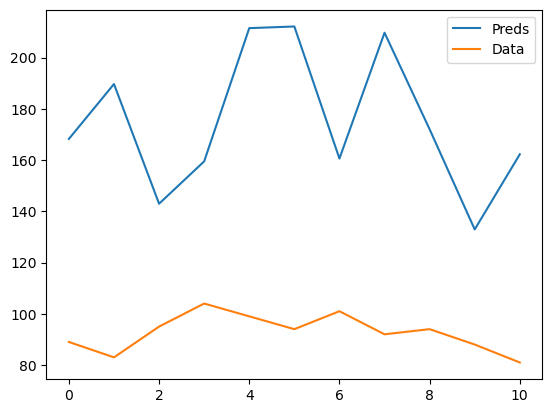

In [28]:
# "训练集效果图"
pred_value = y_test_pred_total[len(y_test_pred_total)-1]    
true_value = trainY[:,-1,0] 

pred_value = scaler.inverse_transform(pred_value.flatten().reshape(-1, 1))
true_value = scaler.inverse_transform(true_value.reshape(-1, 1))

plt.plot(pred_value, label="Preds")    # 预测值
plt.plot(true_value[:11], label="Data")    # 真实值
plt.legend()
plt.show()